# Library and Data Importing

# Importing code

In [114]:
import pyiast
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import pickle
import time
import os
import scipy.optimize as optim
import matplotlib.pyplot as plt

df_NAME=pd.read_csv("HEAT_0215.csv")

bins_CO2 = []
bins_H2S = []
for nam in df_NAME["NAME"]:
    f_tmp = open("iso_"+nam+"_saved.bin",'rb')
    bin_tmp = np.array(pickle.load(f_tmp))
    bins_CO2.append(bin_tmp[[False, True, True]]) ## Pick 1 = CO2, 2 = CH4 
    f_tmp.close()
for nam in df_NAME["NAME"]:
    f_tmp = open("iso_"+nam+"_saved.bin",'rb') ## 0 = H2S , 1 = CO2, 2 = CH4
    bin_tmp = np.array(pickle.load(f_tmp))
    bins_H2S.append(bin_tmp[[True, False, True]]) ## Pick 0 = H2S and 2 = CH4
    f_tmp.close()

Names_CO2=df_NAME["NAME"].to_numpy()
Names_H2S=df_NAME["NAME"].to_numpy()
dH_CO2 = np.array([df_NAME["CO2_Heat"], df_NAME["CH4_Heat"]]).T
dH_H2S = np.array([df_NAME["H2S_Heat"],df_NAME["CH4_Heat"]]).T

### Importing selectivity data ###
df_selectivity = pd.read_csv('selectivity_data.csv')

Names_selectivity = df_selectivity['Name'].to_numpy()
sel_10_H2S = df_selectivity['10_H2S_CH4'].to_numpy()
sel_10_CO2 = df_selectivity['10_CO2_CH4'].to_numpy()

sel_50_H2S = df_selectivity['50_H2S_CH4'].to_numpy()
sel_50_CO2 = df_selectivity['50_CO2_CH4'].to_numpy()



In [116]:
for n1,n2 in zip(Names_CO2, Names_selectivity):
    print(n1,'  ',n2)

ACO_0    ACO_0
AEI_0    AEI_0
AEI_1    AEI_1
AEL_0    AEL_0
AEL_1    AEL_1
AEL_2    AEL_2
AET_0    AET_0
AET_1    AET_1
AFI_0    AFI_0
AFI_1    AFI_1
AFN_0    AFN_0
AFO_0    AFO_0
AFO_1    AFO_1
AFR_0    AFR_0
AFR_1    AFR_1
AFS_0    AFS_0
AFS_1    AFS_1
AFT_0    AFT_0
AFT_1    AFT_1
AFV    AFV
AFX_0    AFX_0
AFX_1    AFX_1
AFY_0    AFY_0
AHT_1    AHT_1
APC_1    APC_1
APC_2    APC_2
APD_0    APD_0
ASV_0    ASV_0
ATN_0    ATN_0
ATN_1    ATN_1
ATO_0    ATO_0
ATO_1    ATO_1
ATS_0    ATS_0
ATS_1    ATS_1
ATT_0    ATT_0
ATT_1    ATT_1
ATV_0    ATV_0
AVE    AVE
AVL    AVL
AWO_0    AWO_0
AWO_1    AWO_1
AWW_0    AWW_0
BEA_0    BEA_0
BEA_1    BEA_1
BEA_B_1    BEA_B_1
BEC_0    BEC_0
BEC_2    BEC_2
BOF_0    BOF_0
BOG_0    BOG_0
BOG_1    BOG_1
BOZ_0    BOZ_0
BPH_0    BPH_0
BRE_1    BRE_1
BSV_0    BSV_0
CAN_0    CAN_0
CAN_1    CAN_1
CDO_0    CDO_0
CDO_1    CDO_1
CFI_0    CFI_0
CFI_1    CFI_1
CGF_0    CGF_0
CGS_0    CGS_0
CHA_0    CHA_0
CLO_0    CLO_0
CON_0    CON_0
CON_1    CON_1
CON_2    CON_2
CSV

## Data Size:

In [19]:
print('[Size of Data (array or list)]')
print()
print('Names_CO2: ', len(Names_CO2))
print('dH_CO2:    ', np.array(dH_CO2).shape)
print('bins_CO2:  ', np.array(bins_CO2).shape)
print()
print('Names_H2S: ', len(Names_H2S))
print('dH_H2S:    ', np.array(dH_H2S).shape)
print('bins_H2S:  ', np.array(bins_H2S).shape)

[Size of Data (array or list)]

Names_CO2:  346
dH_CO2:     (346, 2)
bins_CO2:   (346, 2)

Names_H2S:  346
dH_H2S:     (346, 2)
bins_H2S:   (346, 2)


# PSA Functions

## iso_mix: Mixture Isotherm

In [20]:
Arrh = lambda T,dH ,T_ref: np.exp(-dH/8.3145*(1/T - 1/T_ref)) # Arrhenius equation (Clasius-Clapeyron Equation)

## Isothermal mixture isotherm
def iso_mix(P_par, T, iso_list, dH_list,Tref_list):
    P_norm = []
    for (p,dh,tref) in zip(P_par, dH_list,Tref_list):
        p_n = Arrh(T,dh,tref)*p 
        P_norm.append(p_n)
    P_norm_arr = np.array(P_norm)
    #print(P_norm_mat.T)
    if P_norm_arr.ndim > 1:
        for i in range(len(P_norm[0])):
            p_tmp = P_norm_arr[i,:]
            p_tmp[p_tmp<0.000001] = 0.000001
            q_IAST_tmp = pyiast.iast(p_tmp,
                                     iso_list,
                                     warningoff=True)
    else:
        try:
            p_tmp = P_norm_arr
            p_tmp[p_tmp<0.000001] = 0.000001
            #print(p_tmp)
            q_IAST_tmp = pyiast.iast(p_tmp,
                                    iso_list,
                                     warningoff=True)
        except:    
            try:
                #print('Initial guess error with P = ',P_par)
                x_IG = np.ones(len(p_tmp))/len(p_tmp)
                q_IAST_tmp = pyiast.iast(p_tmp,
                                        iso_list,adsorbed_mole_fraction_guess = x_IG,
                                        warningoff=True)
            except:
                try:
                    arg_min = np.argmin(p_tmp)
                    p_tmp[p_tmp<0.000001] = 0.000001
                    x_IG = 0.05*np.ones(len(p_tmp))
                    x_IG[arg_min] = 1 - 0.05*(len(p_tmp)-1)
                    #print(x_IG)
                    q_IAST_tmp = pyiast.iast(p_tmp,
                                            iso_list,adsorbed_mole_fraction_guess = x_IG,
                                            warningoff=True)

                except:
                    try:
                        arg_max = np.argmax(p_tmp)
                        p_tmp[p_tmp<0.000001] = 0.000001
                        x_IG = 0.05*np.ones(len(p_tmp))
                        x_IG[arg_max] = 1 - 0.05*(len(p_tmp)-1)
                        #print(x_IG)
                        q_IAST_tmp = pyiast.iast(p_tmp,
                                                iso_list,adsorbed_mole_fraction_guess = x_IG,
                                                warningoff=True)        
                    except:
                        try:
                            arg_max = np.argmax(p_tmp)
                            p_tmp[p_tmp<0.000001] = 0.000001
                            x_IG = 0.15*np.ones(len(p_tmp))
                            x_IG[arg_max] = 1 - 0.15*(len(p_tmp)-1)
                            #print(x_IG)
                            q_IAST_tmp = pyiast.iast(p_tmp,
                                                iso_list,adsorbed_mole_fraction_guess = x_IG,
                                                warningoff=True)
                        except:
                            try:
                                arg_min = np.argmin(p_tmp)
                                p_tmp[p_tmp<0.000001] = 0.000001
                                x_IG = 0.01*np.ones(len(p_tmp))
                                x_IG[arg_min] = 1 - 0.01*(len(p_tmp)-1)
                                #print(x_IG)
                                q_IAST_tmp = pyiast.iast(p_tmp,
                                            iso_list,adsorbed_mole_fraction_guess = x_IG,
                                            warningoff=True)

                            except:
                                try:
                                    arg_max = np.argmax(p_tmp)
                                    p_tmp[p_tmp<0.000001] = 0.000001
                                    x_IG = 0.01*np.ones(len(p_tmp))
                                    x_IG[arg_max] = 1 - 0.01*(len(p_tmp)-1)
                                    #print(x_IG)
                                    q_IAST_tmp = pyiast.iast(p_tmp,
                                                    iso_list,adsorbed_mole_fraction_guess = x_IG,
                                                warningoff=True)        
                                except:
                                    p_tmp[p_tmp<0.000001] = 0.000001
                                    x_IG = [0.9999, 0.0001]
                                    #print(x_IG)
                                    q_IAST_tmp = pyiast.iast(p_tmp,
                                                    iso_list,adsorbed_mole_fraction_guess = x_IG,
                                                warningoff=True)    
           
    return q_IAST_tmp

## sat_fraction: Saturation Region Function

In [21]:
def sat_fraction(y_lead,q_lead_array, y_follow,q_follow_array):
    q_sat_lead_part, q_sat_lead_tot, q_des_lead = q_lead_array
    q_sat_fo, q_des_fo = q_follow_array
    numo = y_follow*(q_sat_lead_part - q_des_lead)+y_lead*q_des_fo
    denom = y_follow*(q_sat_lead_part - q_sat_lead_tot)+y_lead*q_sat_fo
    sat_frac = numo/denom
    return sat_frac

## x2x: Single Cycle Function 

In [10]:
def x2x(x_ini,P_high,P_low,
        iso_input, dH_input, Tref_input, 
        yfeed,Tfeed):
    iso_1 = iso_input[0] # Heavy (CO2 or H2S)
    iso_2 = iso_input[1] # Methane (CH4)
    iso  = [iso_1,iso_2]
    dH_1, dH_2 = dH_input[:2]         # (kJ/mol): Heat of adsorption
    dH = np.array([dH_1,dH_2])*1000    # (J/mol): Heat of adsorption 
    P_low_part = np.array(x_ini)*P_low      # (bar): partial pressure
    P_high_part = np.array(yfeed)*P_high    # (bar): partial pressure
    ### Uptakes
    #print(P_low_part)
    P_low_part = np.reshape(P_low_part,len(iso))
    q_des = iso_mix(P_low_part,Tfeed,iso,
                    dH,Tref_input)
    #print(P_high_part)
    P_high_part = np.reshape(P_high_part,len(iso))
    q_sat_tot = iso_mix(P_high_part,Tfeed,iso,
                        dH,Tref_input)
    Dq_tot = q_sat_tot-q_des
    ### Leading component ?
    sat_extent = np.array(yfeed)/Dq_tot # Saturation extent kg/mol
    ind_lead_tot = np.argmax(sat_extent)
    dq = q_sat_tot - q_des
    x_out = dq/(np.sum(dq))
    return x_out,ind_lead_tot


## rec: PSA function for (recovery, leading component, purity at CSS)

In [22]:

def rec(x_ini,P_high,P_low,
        iso_input, dH_input, Tref_input, 
        yfeed,Tfeed):
    def x_err(xx):
        x_new,_ = x2x([xx, 1-xx],P_high,P_low,
                           iso_input, dH_input, Tref_input, 
                           yfeed,Tfeed)
        return (xx-x_new[0])**2
    #sol = optim.minimize(x_err,x_ini,method='COBYLA')
    sol = optim.least_squares(x_err,x_ini,bounds = [0,1])
    x_sol = sol.x
    _,i_lead = x2x([x_sol, 1- x_sol],P_high,P_low,
                   iso_input, dH_input, Tref_input, 
                   yfeed,Tfeed)
    #if i_lead  < 0.5:
    #    return -1
    Recovery = 1-(1-x_sol)/x_sol*yfeed[0]/yfeed[1]
    if Recovery < 0 or Recovery > 1:
        Recovery = 1-x_sol/(1-x_sol)*yfeed[1]/yfeed[0]
    return Recovery, i_lead, x_sol
  #  return x_sol, i_lead, x_sol
    

In [26]:
## E_per_ndot: Energy per unit mass

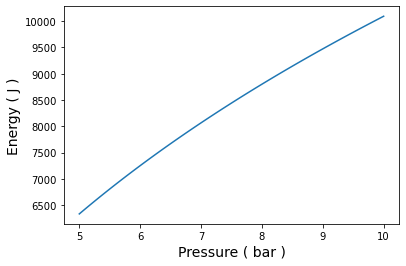

In [23]:
gamma = 1.4
#eta_ef = 0.8
def E_per_ndot(P_h, P_l,T_in,eta_eff):
    P_ratio_term = (P_h/P_l)**((gamma-1)/gamma)-1
    E_comp = (gamma)/(gamma-1)*(8.3145*T_in/eta_eff)*P_ratio_term
    return E_comp
Ph_ran = np.linspace(5,10, 101)
E_res = []
### TESTING ###
for ph in Ph_ran:
    E_tmp = E_per_ndot(ph,1,298.15, 0.8)
    E_res.append(E_tmp)
plt.plot(Ph_ran, np.array(E_res))
plt.xlabel('Pressure ( bar )',fontsize = 14)
plt.ylabel('Energy ( J )',fontsize = 14)
plt.show()
### TESTING ###


# RUN: CO2 case

In [144]:
P_h_range = np.arange(2.5,50.1,0.5)

T_feed_in = 343         # (K) temperature or 298K
T_tri = [298.15,]*2
#y_feed_in = np.array([0.83356,0.1644])
y_meth = 8/10
#y_ethy = 0.83356
y_feed_in = np.array([1-y_meth,y_meth])
Rec_list_set = []
leading_index_set = []
xx_list_set = []
#Pl_list = np.linspace(0.004,0.5,30)


for binn,dH,nam in zip(bins_CO2,dH_CO2,Names_CO2):
    Rec_list = []
    leading_index = []
    xx_list = []
    x_guess = np.array([0.10,0.90])
    for ph in P_h_range:
        rec_tmp,l_ind,x_tmp = rec(x_guess[0], ph,1,
                                  binn, dH, T_tri,y_feed_in, T_feed_in)
        #x_guess[0] = x_tmp*1.01
        Rec_list.append(rec_tmp)
        leading_index.append(l_ind)
        xx_list.append(x_tmp)
    Rec_list_set.append(Rec_list)
    leading_index_set.append(leading_index)
    xx_list_set.append(xx_list)
    print(nam)
    #print(Rec_list[-1])

ACO_0
AEI_0
AEI_1
AEL_0
AEL_1
AEL_2
AET_0
AET_1
AFI_0
AFI_1
AFN_0
AFO_0
AFO_1
AFR_0
AFR_1
AFS_0
AFS_1
AFT_0
AFT_1
AFV
AFX_0
AFX_1
AFY_0
AHT_1
APC_1
APC_2
C:\ProgramData\Anaconda3\lib\site-packages\pyiast\isotherms.py:354: RuntimeWarning: invalid value encountered in log
  return self.params["M"] * np.log(1.0 + self.params["Ka"] * pressure
APD_0
ASV_0
ATN_0
ATN_1
ATO_0
ATO_1
ATS_0
ATS_1
ATT_0
ATT_1
ATV_0
AVE
AVL
AWO_0
AWO_1
AWW_0
BEA_0
BEA_1
BEA_B_1
BEC_0
BEC_2
BOF_0
BOG_0
BOG_1
BOZ_0
BPH_0
BRE_1
BSV_0
CAN_0
CAN_1
CDO_0
CDO_1
CFI_0
CFI_1
CGF_0
CGS_0
CHA_0
CLO_0
CON_0
CON_1
CON_2
CSV
CZP_0
DAC_0
DDR_0
DDR_1
DFO_0
DFO_1
DFT_0
DON_0
DON_1
EAB_0
EAB_1
EAB_2
EDI_0
EDI_2
EMT_0
EMT_1
EMT_2
EON_0
EON_1
EPI_0
EPI_1
ERI_0
ERI_1
ERI_2
ESV_0
ESV_1
ETL
ETR_0
ETR_1
EUO_0
EUO_1
EWS
EZT_0
EZT_1
FAU_0
FAU_1
FAU_2
FAU_3
FAU_4
FAU_5
FAU_6
FER_0
FER_1
FER_2
GIS_0
GIS_1
GIS_2
GIS_3
GIS_4
GIS_5
GIS_6
GME_0
GME_1
GON_0
GON_1
GOO_0
HEU_0
HEU_1
HEU_2
IFO_0
IFO_1
IFR_0
IFR_1
IFT
IFU
IFW
IFY
IHW_0
IHW_1
IMF_0
IMF

In [174]:
xx_sort_tmp = []
for i in range(len(xx_list_set)):
    xx_tmm = np.reshape(np.array(xx_list_set[i]),[-1])
    xx_sort_tmp.append(xx_tmm)
xx_sort_tmp = np.array(xx_sort_tmp)

Sort_target = np.reshape(np.array(xx_sort_tmp)[:,-1],-1)
#print(Sort_target)
arg_st = np.argsort(Sort_target)[::-1]
Name_sort = np.array(Names_CO2)[arg_st]

xx_sort = xx_sort_tmp[arg_st,:]
leading_sort = np.array(leading_index_set)[arg_st]
Rec_list_sort= np.array(Rec_list_set)[arg_st]

### Selectivity sorting ### 

sel_10_CO2_sort = sel_10_CO2[arg_st]
sel_50_CO2_sort = sel_50_CO2[arg_st]

#print(P_h_range[-5]*100)
#print(Name_sort)
#print(Rec_sort[:,-5])

In [175]:
iii = 1
for NNN in Name_sort[:8]:
    print('{}:'.format(iii),'{0:s} //'.format(NNN), 'Index : {}'.format(arg_st[iii-1]) )
    iii = iii+1

1: CDO_1 // Index : 57
2: AEI_0 // Index : 1
3: RRO_0 // Index : 256
4: WEI_0 // Index : 340
5: ITW_1 // Index : 155
6: VSV_0 // Index : 339
7: TSC_0 // Index : 322
8: FAU_0 // Index : 102


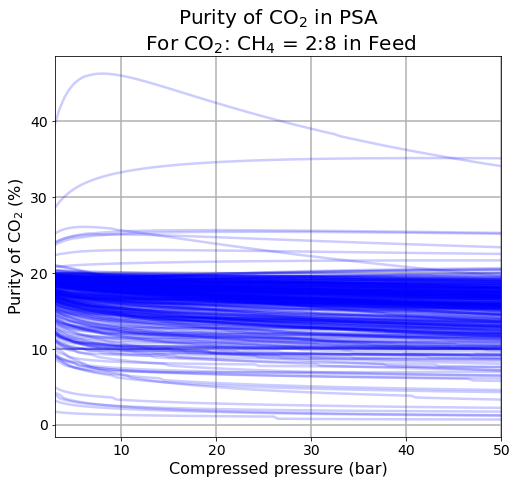

In [240]:
line_len = [1,2,4]
space_len = [1,2,4]
l_style = [(0,())]
for line in line_len:
    for space in space_len:
        style_temp = (line, space)
        l_style.append((0,style_temp))
L_styles = ['solid','dotted','dashdot','dashed'] + [(0,(3,5,1,5,1,5))]
c_list = ['k','b','g','r']
cc = 0
lc = 0
## Semilog graph
plt.figure(figsize= [8,7])
for RR,nn in zip(xx_sort,Name_sort):
    plt.plot(P_h_range,np.array(RR)*100,label = nn,
                 color = 'b',linewidth = 2.5,alpha=0.2)
    #c_list[cc]
   # linestyle =L_styles[lc]
    lc = lc + 1
    if lc  > len(L_styles)-1:
        cc = cc + 1
    if lc > len(L_styles)-1:
        lc = 0
    if cc > len(c_list)-1:
        cc = 0
#plt.plot([0,P_h_range[-1]],[90 ,90],ls='--',lw='3.5',color='r')
## Grid
plt.grid(which = 'major',ls ='-',linewidth = 1.5)
plt.grid(which = 'minor',ls ='-.',linewidth = 1.1)
## Legend
#plt.legend(fontsize = 13,loc = (1.02,0.08))
## x,y axis
plt.xlabel('Compressed pressure (bar)',fontsize = 16)
plt.ylabel('Purity of CO$_2$ (%)',fontsize= 16)
plt.xlim([3.0, 50])
#plt.xticks(ticks= [1,2,3,4,5,6,7,8,9,10,11,12,13,14],
#           labels = ['1','2','3','4','5','6','7','8','9','10','11','12','13','14'],
#           fontsize = 12.5)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
#plt.yticks(ticks= [10,20,30,40,50,60,70,80,90,100],
#           labels = ['10','20','30','40','50','60','70','80','90','100'],
#           fontsize = 14)
plt.title('Purity of CO$_2$ in PSA\n For CO$_2$: CH$_4$ = {0:1.0f}:{1:1.0f} in Feed'.format(y_feed_in[0]*10,10-y_feed_in[0]*10),fontsize = 20)
plt.savefig('CO2_Purity_PSA_1vs9.png')
plt.show()

# CO2 case: Sort Based on Maximum X

In [186]:
xx_max = np.max(xx_sort,1)

arg_xmax= np.argsort(xx_max)[::-1]
xx_max_sort = xx_max[arg_xmax]
Names_max_sort = Name_sort[arg_xmax]

### Make arg_more10 anad arg_less10 ###
arg_more10 = xx_max_sort>0.21
arg_less10 = (1-arg_more10)>0.5

### Classify the adsorbents ###
xx_CH4_raf = xx_max_sort[arg_more10] ## When CH4 is raffinate
xx_rest_CH4 = 1-xx_max_sort[arg_less10] ## CH4 purity when CH4 is captured (raf = CO2)
sel_10_CO2_CH4_raf = sel_10_CO2_sort[arg_more10] ## 10 bar sel when CH4 is raff.
sel_10_CO2_rest =  sel_10_CO2_sort[arg_less10]   ## 10 bar sel when CH4 is capt.
sel_50_CO2_CH4_raf = sel_50_CO2_sort[arg_more10] ## 50 bar sel when CH4 is raff.
sel_50_CO2_rest =  sel_50_CO2_sort[arg_less10]   ## 50 bar sel when CH4 is capt.

Names_CH4_raf = Names_max_sort[arg_more10] 
Names_rest = Names_max_sort[arg_less10]
Recs_CH4_raf = 1-(1-xx_CH4_raf)/(1- y_feed_in[0])*y_feed_in[0]/xx_CH4_raf

In [187]:
import scipy.stats as stats

In [188]:
### BEST SELECTIVITY ?? ###
arg_sel_10_CO2 = np.argsort(sel_10_CO2)[::-1]
arg_sel_50_CO2 = np.argsort(sel_50_CO2)[::-1]

Name_best_sel_10_CO2 = Names_CO2[arg_sel_10_CO2[0]]
Name_best_sel_50_CO2 = Names_CO2[arg_sel_50_CO2[0]]
print('Best Selectivity is')
print('@ 10 bar')
print(Name_best_sel_10_CO2, ': ', sel_10_CO2[arg_sel_10_CO2[0]])
print('@ 50 bar')
print(Name_best_sel_50_CO2, ': ', sel_50_CO2[arg_sel_50_CO2[0]])
print()
print('10 bar selectivity case:')
for nnn,selll in zip(Names_CO2[arg_sel_10_CO2[:20]], sel_10_CO2[arg_sel_10_CO2[:20]]):
    print(nnn, ': {0:.3f}'.format(selll))
print()
print('50 bar selectivity case:')
for nnn,selll in zip(Names_CO2[arg_sel_50_CO2[:20]], sel_50_CO2[arg_sel_50_CO2[:20]]):
    print(nnn, ': {0:.3f}'.format(selll))

Best Selectivity is
@ 10 bar
RRO_0 :  1.4477379080000001
@ 50 bar
ACO_0 :  1.312496669

10 bar selectivity case:
RRO_0 : 1.448
ITW_1 : 1.380
WEI_0 : 1.240
VSV_0 : 1.213
AET_1 : 1.030
CFI_1 : 1.010
SAO_0 : 0.996
IWS_1 : 0.992
SAO_1 : 0.990
AFI_0 : 0.984
AFI_1 : 0.982
ISV_1 : 0.981
IFO_1 : 0.981
IWS_0 : 0.979
CFI_0 : 0.977
IRY : 0.976
DON_0 : 0.975
BEC_2 : 0.971
BEC_0 : 0.970
VFI_1 : 0.968

50 bar selectivity case:
ACO_0 : 1.312
GIS_6 : 1.311
ATN_0 : 1.301
AWO_0 : 1.253
ZON_0 : 1.252
CDO_1 : 1.251
YUG_0 : 1.250
GIS_5 : 1.248
CGF_0 : 1.245
GOO_0 : 1.243
GIS_1 : 1.241
EDI_2 : 1.240
EDI_0 : 1.240
JOZ_0 : 1.223
AWO_1 : 1.222
BRE_1 : 1.220
GIS_4 : 1.211
ATN_1 : 1.206
EPI_0 : 1.205
EPI_1 : 1.204


# CO2 Case: Separate Graphs

SpearmanrResult(correlation=-0.48571428571428577, pvalue=0.32872303206997094)
SpearmanrResult(correlation=-0.6423143725575337, pvalue=8.598170578913493e-07)
SpearmanrResult(correlation=0.14285714285714288, pvalue=0.7871720116618075)
SpearmanrResult(correlation=-0.018671805038493482, pvalue=0.8997612033952327)


Text(1.2, 46, 'SRCC$_2$ = -0.019')

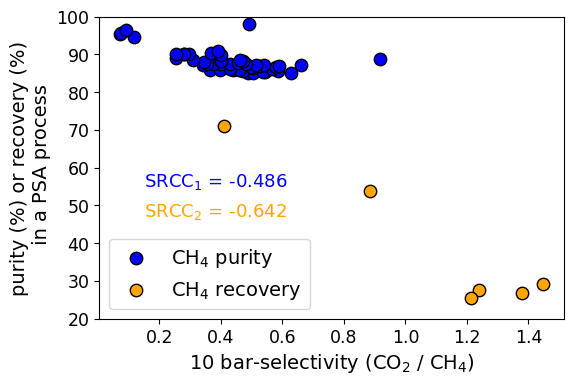

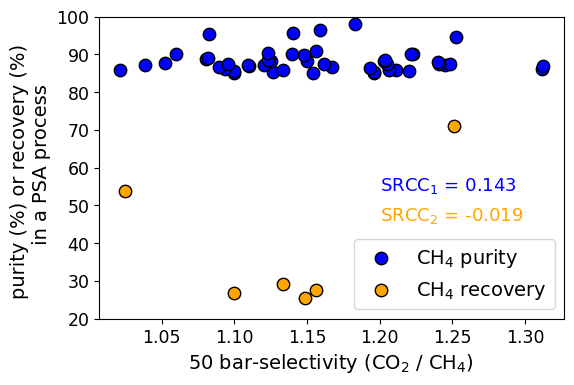

In [279]:
###############################################
#################  SRCC   #####################
###############################################

### Condition: over 20% recovery ###
s_res_CO2_CH4_raf_50 = stats.spearmanr(sel_50_CO2_CH4_raf[Recs_CH4_raf > 0.2], Recs_CH4_raf[Recs_CH4_raf > 0.2])
s_res_CO2_CH4_raf_10 = stats.spearmanr(sel_10_CO2_CH4_raf[Recs_CH4_raf > 0.2], Recs_CH4_raf[Recs_CH4_raf > 0.2])

### Condition: over 85% CH4 purity ###
s_res_CO2_rest_10 = stats.spearmanr(sel_10_CO2_rest[xx_rest_CH4 > 0.85], xx_rest_CH4[xx_rest_CH4 > 0.85])
s_res_CO2_rest_50 = stats.spearmanr(sel_50_CO2_rest[xx_rest_CH4 > 0.85], xx_rest_CH4[xx_rest_CH4 > 0.85])

print(s_res_CO2_CH4_raf_10)
print(s_res_CO2_rest_10)
print(s_res_CO2_CH4_raf_50)
print(s_res_CO2_rest_50)


###############################################
################## 10 bar  ####################
###############################################


### Scatter for CH4 capturing case (10 bar) ###
plt.figure(dpi = 100)
plt.scatter(sel_10_CO2_rest[xx_rest_CH4 > 0.85], xx_rest_CH4[xx_rest_CH4 > 0.85]*100, 
s = 80,c='blue', edgecolors= 'k',
label = 'CH$_{4}$ purity')

plt.xticks(fontsize = 12.5)
plt.yticks(fontsize = 12.5)
plt.xlabel('10 bar-selectivity (CO$_{2}$ / CH$_{4}$)', fontsize = 14)
#plt.ylabel('CH$_{4}$ purity in a PSA process', fontsize = 14)

### Scatter for CH4 producing case (10 bar) ### 
plt.scatter(sel_10_CO2_CH4_raf[Recs_CH4_raf > 0.2], Recs_CH4_raf[Recs_CH4_raf > 0.2]*100,
s = 80,c='orange', edgecolors= 'k',
label = 'CH$_{4}$ recovery')

plt.xlabel('10 bar-selectivity (CO$_{2}$ / CH$_{4}$)', fontsize = 14)
#plt.ylabel('CH$_{4}$ recovery in a PSA process', fontsize = 14)
plt.ylabel('purity (%) or recovery (%)\n in a PSA process', fontsize = 14)

plt.ylim([20,100])
plt.legend(fontsize = 14)

plt.text(0.15,55, 'SRCC$_1$ = {0:.3f}'.format(s_res_CO2_CH4_raf_10[0]),
fontdict = {'color':'blue','size': 13})
plt.text(0.15,55-8, 'SRCC$_2$ = {0:.3f}'.format(s_res_CO2_rest_10[0]), 
fontdict = {'color':'orange','size':13})

###############################################
################## 50 bar  ####################
###############################################

### Scatter for CH4 capturing case (50 bar) ###
plt.figure(dpi = 100)
plt.scatter(sel_50_CO2_rest[xx_rest_CH4 > 0.85], xx_rest_CH4[xx_rest_CH4 > 0.85]*100, 
s = 80,c='blue', edgecolors= 'k',
label = 'CH$_{4}$ purity')

plt.xticks(fontsize = 12.5)
plt.yticks(fontsize = 12.5)
plt.xlabel('50 bar-selectivity (CO$_{2}$ / CH$_{4}$)', fontsize = 14)
#plt.ylabel('CH$_4$ purity in a PSA process', fontsize = 14)


### Scatter for CH4 producing case (50 bar) ###
plt.scatter(sel_50_CO2_CH4_raf[Recs_CH4_raf > 0.2], Recs_CH4_raf[Recs_CH4_raf > 0.2]*100,
s = 80,c='orange', edgecolors= 'k',
label = 'CH$_{4}$ recovery')
plt.xticks(fontsize = 12.5)
plt.yticks(fontsize = 12.5)
plt.xlabel('50 bar-selectivity (CO$_{2}$ / CH$_{4}$) ', fontsize = 14)
#plt.ylabel('$_{4}$ recovery in a PSA process', fontsize = 14)
plt.ylabel('purity (%) or recovery (%) \n in a PSA process', fontsize = 14)

plt.ylim([20,100])
plt.legend(fontsize = 14)

plt.text(1.2,54, 'SRCC$_1$ = {0:.3f}'.format(s_res_CO2_CH4_raf_50[0]),
fontdict = {'color':'blue','size': 13})
plt.text(1.2,54-8, 'SRCC$_2$ = {0:.3f}'.format(s_res_CO2_rest_50[0]), 
fontdict = {'color':'orange','size':13})




SpearmanrResult(correlation=-0.48571428571428577, pvalue=0.32872303206997094)
SpearmanrResult(correlation=-0.6423143725575337, pvalue=8.598170578913493e-07)
SpearmanrResult(correlation=0.14285714285714288, pvalue=0.7871720116618075)
SpearmanrResult(correlation=-0.018671805038493482, pvalue=0.8997612033952327)


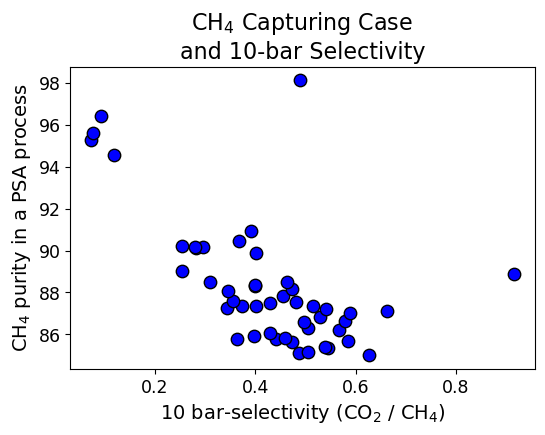

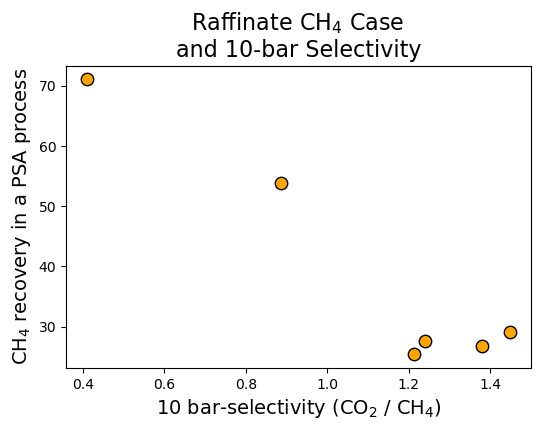

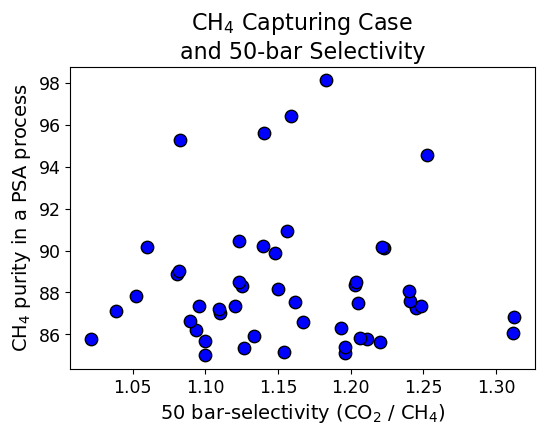

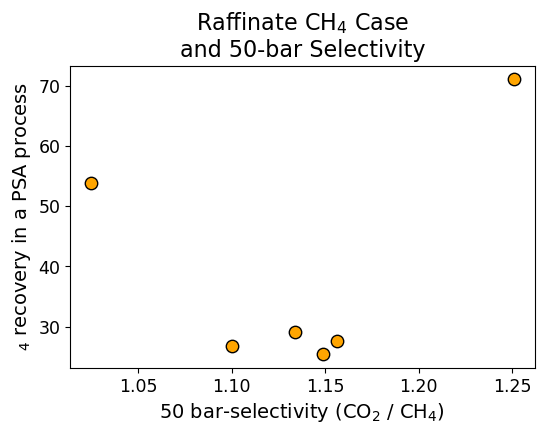

In [210]:
###############################################
############### 10 bar  #######################
###############################################


### Scatter for CH4 capturing case (10 bar) ###
plt.figure(dpi = 100)
plt.scatter(sel_10_CO2_rest[xx_rest_CH4 > 0.85], xx_rest_CH4[xx_rest_CH4 > 0.85]*100, 
s = 80,c='blue', edgecolors= 'k',
label = 'CH$_{4}$ purity')

plt.xticks(fontsize = 12.5)
plt.yticks(fontsize = 12.5)
plt.xlabel('10 bar-selectivity (CO$_{2}$ / CH$_{4}$)', fontsize = 14)
plt.ylabel('CH$_{4}$ purity in a PSA process', fontsize = 14)
plt.title('CH$_{4}$ Capturing Case \nand 10-bar Selectivity',fontsize = 16)

### Scatter for CH4 producing case (10 bar) ### 
plt.figure(dpi = 100)
plt.scatter(sel_10_CO2_CH4_raf[Recs_CH4_raf > 0.2], Recs_CH4_raf[Recs_CH4_raf > 0.2]*100,
s = 80,c='orange', edgecolors= 'k',
label = 'CH$_{4}$ recovery')
#plt.title('Raffinate CH$_4$ Case \nand 10 bar Selectivity')
plt.xlabel('10 bar-selectivity (CO$_{2}$ / CH$_{4}$)', fontsize = 14)
plt.ylabel('CH$_{4}$ recovery in a PSA process', fontsize = 14)
plt.title('Raffinate CH$_{4}$ Case \nand 10-bar Selectivity',fontsize = 16)

#plt.legend(fontsize = 14)

###############################################
############### 50 bar  #######################
###############################################

### Scatter for CH4 capturing case (50 bar) ###
plt.figure(dpi = 100)
plt.scatter(sel_50_CO2_rest[xx_rest_CH4 > 0.85], xx_rest_CH4[xx_rest_CH4 > 0.85]*100, 
s = 80,c='blue', edgecolors= 'k',
label = 'CH$_{4}$ purity')

plt.xticks(fontsize = 12.5)
plt.yticks(fontsize = 12.5)
plt.xlabel('50 bar-selectivity (CO$_{2}$ / CH$_{4}$)', fontsize = 14)
plt.ylabel('CH$_4$ purity in a PSA process', fontsize = 14)
plt.title('CH$_4$ Capturing Case \nand 50-bar Selectivity',fontsize = 16)

### Scatter for CH4 producing case (50 bar) ###
plt.figure(dpi = 100)
plt.scatter(sel_50_CO2_CH4_raf[Recs_CH4_raf > 0.2], Recs_CH4_raf[Recs_CH4_raf > 0.2]*100,
s = 80,c='orange', edgecolors= 'k',
label = 'CH$_{4}$ recovery')
plt.xticks(fontsize = 12.5)
plt.yticks(fontsize = 12.5)
plt.xlabel('50 bar-selectivity (CO$_{2}$ / CH$_{4}$) ', fontsize = 14)
plt.ylabel('$_{4}$ recovery in a PSA process', fontsize = 14)
plt.title('Raffinate CH$_{4}$ Case \nand 50-bar Selectivity',fontsize = 16)


#plt.legend(fontsize = 14)

### Condition: over 20% recovery ###
s_res_CO2_CH4_raf_50 = stats.spearmanr(sel_50_CO2_CH4_raf[Recs_CH4_raf > 0.2], Recs_CH4_raf[Recs_CH4_raf > 0.2])
s_res_CO2_CH4_raf_10 = stats.spearmanr(sel_10_CO2_CH4_raf[Recs_CH4_raf > 0.2], Recs_CH4_raf[Recs_CH4_raf > 0.2])

### Condition: over 85% CH4 purity ###
s_res_CO2_rest_10 = stats.spearmanr(sel_10_CO2_rest[xx_rest_CH4 > 0.85], xx_rest_CH4[xx_rest_CH4 > 0.85])
s_res_CO2_rest_50 = stats.spearmanr(sel_50_CO2_rest[xx_rest_CH4 > 0.85], xx_rest_CH4[xx_rest_CH4 > 0.85])

print(s_res_CO2_CH4_raf_10)
print(s_res_CO2_rest_10)
print(s_res_CO2_CH4_raf_50)
print(s_res_CO2_rest_50)

# CO2 Case: Combine Graphs

# CO2 Case: Bar Graph

AEI_0  achieves 46.32%
CDO_1  achieves 35.17%
IWW_0  achieves 26.09%
RRO_0  achieves 25.66%
WEI_0  achieves 25.44%
ITW_1  achieves 25.12%
VSV_0  achieves 23.04%
TSC_0  achieves 21.67%
SZR_0  achieves 21.06%


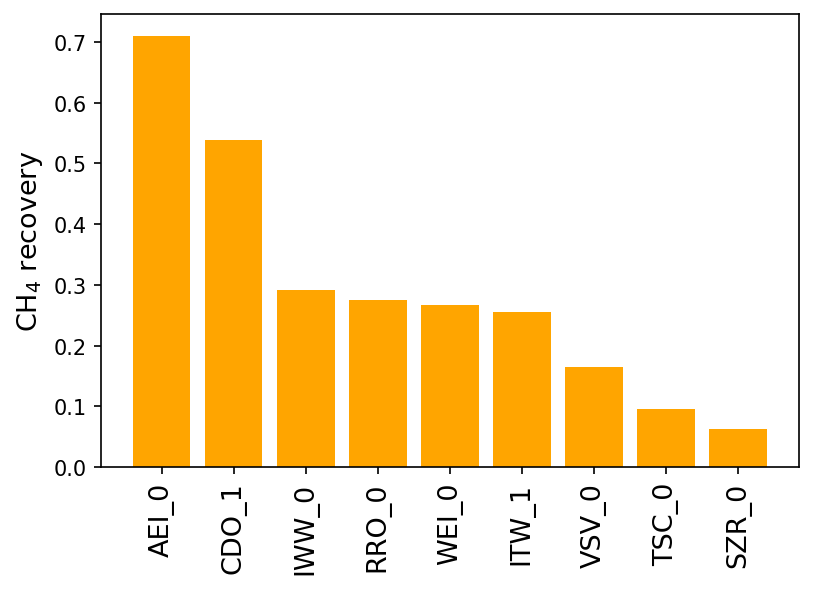

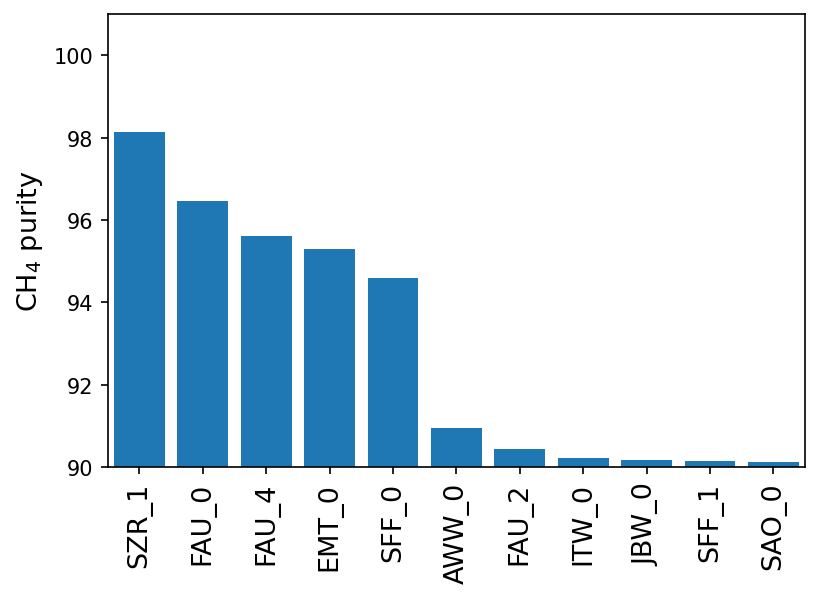

In [236]:

for xxx,nnn in zip(xx_CH4_raf, Names_CH4_raf):
    print(nnn, ' achieves {0:.2f}%'.format(xxx*100))
#recc_max_sort = np.max(Rec_list_sort,1)
#print(xx_max.shape)
#print(recc_max.shape)
plt.figure(dpi = 150)
plt.bar(np.arange(len(Recs_CH4_raf)),Recs_CH4_raf,color = 'orange')
plt.xticks(np.arange(len(Recs_CH4_raf)),labels = Names_CH4_raf, fontsize = 13,
rotation = 90)
plt.ylabel('CH$_{4}$ recovery', fontsize = 13)
plt.savefig('Recovery_CO2_case.png')

plt.figure(dpi = 150)
plt.bar(np.arange(len(xx_rest_CH4)),xx_rest_CH4[::-1]*100)
plt.xticks(np.arange(len(xx_rest_CH4)), labels = Names_rest, fontsize = 13,
rotation = 90)
plt.ylabel('CH$_4$ purity', fontsize= 13)
plt.xlim([-0.5,10.5])
plt.ylim([90,101])
plt.savefig('Purity_CO2_case.png')

# H2S Case

In [241]:
P_h_range = np.arange(2.5,50.1,0.5)

T_feed_in = 343         # (K) temperature or 298K
T_tri = [298.15,]*2
#y_feed_in = np.array([0.83356,0.1644])
y_meth = 8/10
#y_ethy = 0.83356
y_feed_in = np.array([1-y_meth,y_meth])
Rec_list_set = []
leading_index_set = []
xx_list_set = []
#Pl_list = np.linspace(0.004,0.5,30)


for binn,dH,nam in zip(bins_H2S,dH_H2S,Names_H2S):
    Rec_list = []
    leading_index = []
    xx_list = []
    x_guess = np.array([0.10,0.90])
    for ph in P_h_range:
        rec_tmp,l_ind,x_tmp = rec(x_guess[0], ph,1,
                                  binn, dH, T_tri,y_feed_in, T_feed_in)
        #x_guess[0] = x_tmp*1.01
        Rec_list.append(rec_tmp)
        leading_index.append(l_ind)
        xx_list.append(x_tmp)
    Rec_list_set.append(Rec_list)
    leading_index_set.append(leading_index)
    xx_list_set.append(xx_list)
    print(nam)
    #print(Rec_list[-1])

ACO_0
AEI_0
AEI_1
AEL_0
AEL_1
AEL_2
AET_0
AET_1
AFI_0
AFI_1
AFN_0
AFO_0
AFO_1
AFR_0
AFR_1
AFS_0
AFS_1
AFT_0
AFT_1
AFV
AFX_0
AFX_1
AFY_0
AHT_1
APC_1
APC_2
APD_0
ASV_0
ATN_0
ATN_1
ATO_0
ATO_1
ATS_0
ATS_1
ATT_0
ATT_1
ATV_0
AVE
AVL
AWO_0
AWO_1
AWW_0
BEA_0
BEA_1
BEA_B_1
BEC_0
BEC_2
BOF_0
BOG_0
BOG_1
BOZ_0
BPH_0
BRE_1
BSV_0
CAN_0
CAN_1
CDO_0
CDO_1
CFI_0
CFI_1
CGF_0
CGS_0
CHA_0
CLO_0
CON_0
CON_1
CON_2
CSV
CZP_0
DAC_0
DDR_0
DDR_1
DFO_0
DFO_1
DFT_0
DON_0
DON_1
EAB_0
EAB_1
EAB_2
EDI_0
EDI_2
EMT_0
EMT_1
EMT_2
EON_0
EON_1
EPI_0
EPI_1
ERI_0
ERI_1
ERI_2
ESV_0
ESV_1
ETL
ETR_0
ETR_1
EUO_0
EUO_1
EWS
EZT_0
EZT_1
FAU_0
FAU_1
FAU_2
FAU_3
FAU_4
FAU_5
FAU_6
FER_0
FER_1
FER_2
GIS_0
GIS_1
GIS_2
GIS_3
GIS_4
GIS_5
GIS_6
GME_0
GME_1
GON_0
GON_1
GOO_0
HEU_0
HEU_1
HEU_2
IFO_0
IFO_1
IFR_0
IFR_1
IFT
IFU
IFW
IFY
IHW_0
IHW_1
IMF_0
IMF_1
IRN
IRR_0
IRR_1
IRY
ISV_0
ISV_1
ITE_0
ITE_1
ITG
ITH_0
ITH_1
ITR_0
ITR_1
ITT_0
ITV_0
ITW_0
ITW_1
IWR_0
IWR_1
IWS_0
IWS_1
IWV_0
IWV_1
IWW_0
IWW_1
JBW_0
JOZ_0
JRY_0
JSN_0
JSN_1
JSR_0
JST_

In [242]:
xx_sort_tmp = []
for i in range(len(xx_list_set)):
    xx_tmm = np.reshape(np.array(xx_list_set[i]),[-1])
    xx_sort_tmp.append(xx_tmm)
xx_sort_tmp = np.array(xx_sort_tmp)

Sort_target = np.reshape(np.array(xx_sort_tmp)[:,-1],-1)
#print(Sort_target)
arg_st = np.argsort(Sort_target)[::-1]
Name_sort = np.array(Names_CO2)[arg_st]

xx_sort = xx_sort_tmp[arg_st,:]
leading_sort = np.array(leading_index_set)[arg_st]
Rec_list_sort= np.array(Rec_list_set)[arg_st]

### Selectivity sorting ### 

sel_10_H2S_sort = sel_10_H2S[arg_st]
sel_50_H2S_sort = sel_50_H2S[arg_st]

#print(P_h_range[-5]*100)
#print(Name_sort)
#print(Rec_sort[:,-5])

In [243]:
iii = 1
for NNN in Name_sort[:8]:
    print('{}:'.format(iii),'{0:s} //'.format(NNN), 'Index : {}'.format(arg_st[iii-1]) )
    iii = iii+1

1: CDO_1 // Index : 57
2: AEI_0 // Index : 1
3: WEI_0 // Index : 340
4: MON_0 // Index : 203
5: APC_2 // Index : 25
6: APC_1 // Index : 24
7: JBW_0 // Index : 164
8: CZP_0 // Index : 68


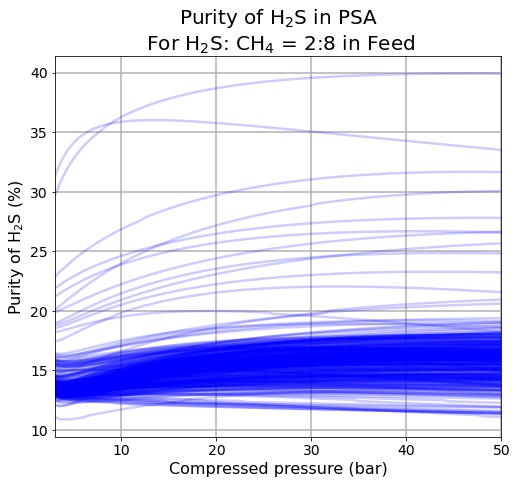

In [264]:
line_len = [1,2,4]
space_len = [1,2,4]
l_style = [(0,())]
for line in line_len:
    for space in space_len:
        style_temp = (line, space)
        l_style.append((0,style_temp))
L_styles = ['solid','dotted','dashdot','dashed'] + [(0,(3,5,1,5,1,5))]
c_list = ['k','b','g','r']
cc = 0
lc = 0
## Semilog graph
plt.figure(figsize= [8,7])
for RR,nn in zip(xx_sort,Name_sort):
    plt.plot(P_h_range,np.array(RR)*100,label = nn,
                 color = 'b',linewidth = 2.5,alpha=0.2)
    #c_list[cc]
   # linestyle =L_styles[lc]
    lc = lc + 1
    if lc  > len(L_styles)-1:
        cc = cc + 1
    if lc > len(L_styles)-1:
        lc = 0
    if cc > len(c_list)-1:
        cc = 0
#plt.plot([0,P_h_range[-1]],[90 ,90],ls='--',lw='3.5',color='r')
## Grid
plt.grid(which = 'major',ls ='-',linewidth = 1.5)
plt.grid(which = 'minor',ls ='-.',linewidth = 1.1)
## Legend
#plt.legend(fontsize = 13,loc = (1.02,0.08))
## x,y axis
plt.xlabel('Compressed pressure (bar)',fontsize = 16)
plt.ylabel('Purity of H$_2$S (%)',fontsize= 16)
plt.xlim([3.0, 50])
#plt.xticks(ticks= [1,2,3,4,5,6,7,8,9,10,11,12,13,14],
#           labels = ['1','2','3','4','5','6','7','8','9','10','11','12','13','14'],
#           fontsize = 12.5)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
#plt.yticks(ticks= [10,20,30,40,50,60,70,80,90,100],
#           labels = ['10','20','30','40','50','60','70','80','90','100'],
#           fontsize = 14)
plt.title('Purity of H$_2$S in PSA\n For H$_2$S: CH$_4$ = {0:1.0f}:{1:1.0f} in Feed'.format(y_feed_in[0]*10,10-y_feed_in[0]*10),fontsize = 20)
plt.savefig('H2S_Purity_PSA_2vs8.png')
plt.show()

# H2S Case: Sorting Based On Maximum Purity


In [249]:

xx_max = np.max(xx_sort,1)

arg_xmax= np.argsort(xx_max)[::-1]
xx_max_sort = xx_max[arg_xmax]
Names_max_sort = Name_sort[arg_xmax]

### Make arg_more10 anad arg_less10 ###
arg_more10 = xx_max_sort>0.21
arg_less10 = (1-arg_more10)>0.5

### Classify the adsorbents ###
xx_CH4_raf_H2S = xx_max_sort[arg_more10] ## When CH4 is raffinate
xx_rest_CH4_H2S = 1-xx_max_sort[arg_less10] ## CH4 purity when CH4 is captured (raf = CO2)
sel_10_H2S_CH4_raf = sel_10_H2S_sort[arg_more10] ## 10 bar sel when CH4 is raff.
sel_10_H2S_rest =  sel_10_H2S_sort[arg_less10]   ## 10 bar sel when CH4 is capt.
sel_50_H2S_CH4_raf = sel_50_H2S_sort[arg_more10] ## 50 bar sel when CH4 is raff.
sel_50_H2S_rest =  sel_50_H2S_sort[arg_less10]   ## 50 bar sel when CH4 is capt.

Names_CH4_raf_H2S = Names_max_sort[arg_more10] 
Names_rest_H2S = Names_max_sort[arg_less10]
Recs_CH4_raf_H2S = 1-(1-xx_CH4_raf_H2S)/(1- y_feed_in[0])*y_feed_in[0]/xx_CH4_raf_H2S


In [250]:
### BEST SELECTIVITY ?? ###
arg_sel_10_H2S = np.argsort(sel_10_H2S)[::-1]
arg_sel_50_H2S = np.argsort(sel_50_H2S)[::-1]

Name_best_sel_10_H2S = Names_H2S[arg_sel_10_H2S[0]]
Name_best_sel_50_H2S = Names_H2S[arg_sel_50_H2S[0]]
print('Best Selectivity is')
print('@ 10 bar')
print(Name_best_sel_10_H2S, ': ', sel_10_H2S[arg_sel_10_H2S[0]])
print('@ 50 bar')
print(Name_best_sel_50_H2S, ': ', sel_50_H2S[arg_sel_50_H2S[0]])
print()
print('10 bar selectivity case:')
for nnn,selll in zip(Names_H2S[arg_sel_10_H2S[:20]], sel_10_H2S[arg_sel_10_H2S[:20]]):
    print(nnn, ': {0:.3f}'.format(selll))
print()
print('50 bar selectivity case:')
for nnn,selll in zip(Names_H2S[arg_sel_50_H2S[:20]], sel_50_H2S[arg_sel_50_H2S[:20]]):
    print(nnn, ': {0:.3f}'.format(selll))

Best Selectivity is
@ 10 bar
MON_0 :  1.8038049930000002
@ 50 bar
MON_0 :  1.55407283

10 bar selectivity case:
MON_0 : 1.804
WEI_0 : 1.759
APC_2 : 1.531
JBW_0 : 1.425
VSV_0 : 1.352
APC_1 : 1.282
RRO_0 : 1.256
ACO_0 : 1.231
CZP_0 : 1.220
YUG_0 : 0.994
ITW_1 : 0.970
NAT_0 : 0.917
ITW_0 : 0.893
GOO_0 : 0.854
SOS_0 : 0.833
ATV_0 : 0.822
PON_1 : 0.822
GIS_1 : 0.810
JRY_0 : 0.810
GIS_4 : 0.788

50 bar selectivity case:
MON_0 : 1.554
WEI_0 : 1.522
APC_2 : 1.469
JBW_0 : 1.189
VSV_0 : 1.177
APC_1 : 1.121
CZP_0 : 1.117
RRO_0 : 1.108
ACO_0 : 0.938
ITW_1 : 0.879
ITW_0 : 0.821
YUG_0 : 0.797
NAT_0 : 0.788
RSN_0 : 0.770
SOS_0 : 0.736
VFI_0 : 0.729
VNI_0 : 0.727
IRY : 0.725
RWY_0 : 0.720
AFI_0 : 0.718


# H2S Case: Combine Graphs

In [295]:
stats.spearmanr(sel_50_H2S_sort,sel_10_H2S_sort)

SpearmanrResult(correlation=0.9056571740926693, pvalue=3.1169895326963784e-130)

SpearmanrResult(correlation=-0.16666666666666669, pvalue=0.668231040071504)
SpearmanrResult(correlation=-0.2692675238393082, pvalue=0.009851523245450954)
SpearmanrResult(correlation=-0.16666666666666669, pvalue=0.668231040071504)
SpearmanrResult(correlation=-0.5414417003329608, pvalue=2.9953247300392664e-08)


Text(1.05, 64, 'SRCC$_2$ = -0.541')

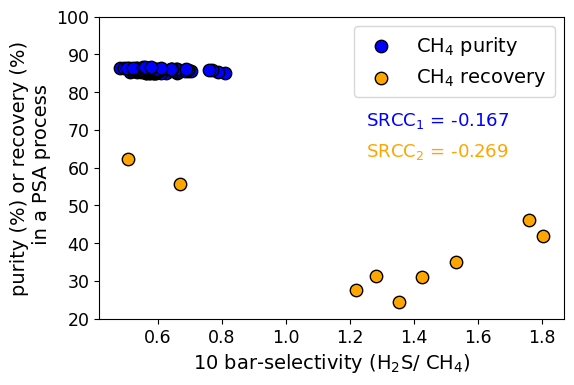

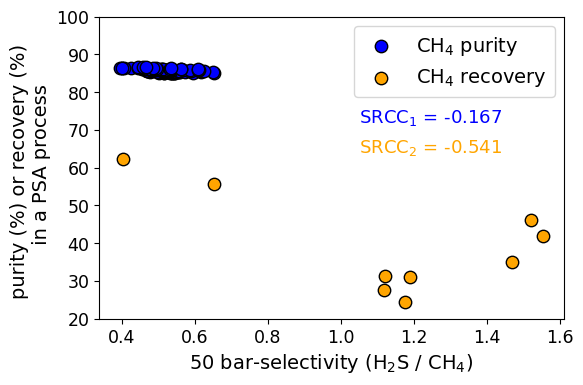

In [288]:
###############################################
#################  SRCC   #####################
###############################################

### Condition: over 20% recovery ###
s_res_H2S_CH4_raf_10 = stats.spearmanr(sel_10_H2S_CH4_raf[Recs_CH4_raf_H2S > 0.2], Recs_CH4_raf_H2S[Recs_CH4_raf_H2S > 0.2])
s_res_H2S_CH4_raf_50 = stats.spearmanr(sel_50_H2S_CH4_raf[Recs_CH4_raf_H2S > 0.2], Recs_CH4_raf_H2S[Recs_CH4_raf_H2S > 0.2])


### Condition: over 85% CH4 purity ###
s_res_H2S_rest_10 = stats.spearmanr(sel_10_H2S_rest[xx_rest_CH4_H2S > 0.85], xx_rest_CH4_H2S[xx_rest_CH4_H2S > 0.85])
s_res_H2S_rest_50 = stats.spearmanr(sel_50_H2S_rest[xx_rest_CH4_H2S > 0.85], xx_rest_CH4_H2S[xx_rest_CH4_H2S > 0.85])

print(s_res_H2S_CH4_raf_10)
print(s_res_H2S_rest_10)
print(s_res_H2S_CH4_raf_50)
print(s_res_H2S_rest_50)


###############################################
################## 10 bar  ####################
###############################################


### Scatter for CH4 capturing case (10 bar) ###
plt.figure(dpi = 100)
plt.scatter(sel_10_H2S_rest[xx_rest_CH4_H2S > 0.85], xx_rest_CH4_H2S[xx_rest_CH4_H2S > 0.85]*100, 
s = 80,c='blue', edgecolors= 'k',
label = 'CH$_{4}$ purity')

plt.xticks(fontsize = 12.5)
plt.yticks(fontsize = 12.5)
plt.xlabel('10 bar-selectivity (H$_{2}$S / CH$_{4}$)', fontsize = 14)
#plt.ylabel('CH$_{4}$ purity in a PSA process', fontsize = 14)

### Scatter for CH4 producing case (10 bar) ### 
plt.scatter(sel_10_H2S_CH4_raf[Recs_CH4_raf_H2S > 0.2], Recs_CH4_raf_H2S[Recs_CH4_raf_H2S > 0.2]*100,
s = 80,c='orange', edgecolors= 'k',
label = 'CH$_{4}$ recovery')

plt.xlabel('10 bar-selectivity (H$_{2}$S/ CH$_{4}$)', fontsize = 14)
#plt.ylabel('CH$_{4}$ recovery in a PSA process', fontsize = 14)
plt.ylabel('purity (%) or recovery (%)\n in a PSA process', fontsize = 14)

plt.ylim([20,100])
plt.legend(fontsize = 14)

plt.text(1.25,71, 'SRCC$_1$ = {0:.3f}'.format(s_res_H2S_CH4_raf_10[0]),
fontdict = {'color':'blue','size': 13})
plt.text(1.25,71-8, 'SRCC$_2$ = {0:.3f}'.format(s_res_H2S_rest_10[0]), 
fontdict = {'color':'orange','size':13})

###############################################
################## 50 bar  ####################
###############################################

### Scatter for CH4 capturing case (50 bar) ###
plt.figure(dpi = 100)
plt.scatter(sel_50_H2S_rest[xx_rest_CH4_H2S > 0.85], xx_rest_CH4_H2S[xx_rest_CH4_H2S > 0.85]*100, 
s = 80,c='blue', edgecolors= 'k',
label = 'CH$_{4}$ purity')

plt.xticks(fontsize = 12.5)
plt.yticks(fontsize = 12.5)
plt.xlabel('50 bar-selectivity (H$_{2}$S / CH$_{4}$)', fontsize = 14)
#plt.ylabel('CH$_4$ purity in a PSA process', fontsize = 14)


### Scatter for CH4 producing case (50 bar) ###
plt.scatter(sel_50_H2S_CH4_raf[Recs_CH4_raf_H2S > 0.2], Recs_CH4_raf_H2S[Recs_CH4_raf_H2S > 0.2]*100,
s = 80,c='orange', edgecolors= 'k',
label = 'CH$_{4}$ recovery')
plt.xticks(fontsize = 12.5)
plt.yticks(fontsize = 12.5)
plt.xlabel('50 bar-selectivity (H$_{2}$S / CH$_{4}$) ', fontsize = 14)
#plt.ylabel('$_{4}$ recovery in a PSA process', fontsize = 14)
plt.ylabel('purity (%) or recovery (%) \n in a PSA process', fontsize = 14)

plt.ylim([20,100])
plt.legend(fontsize = 14)

plt.text(1.05,72, 'SRCC$_1$ = {0:.3f}'.format(s_res_H2S_CH4_raf_50[0]),
fontdict = {'color':'blue','size': 13})
plt.text(1.05,72-8, 'SRCC$_2$ = {0:.3f}'.format(s_res_H2S_rest_50[0]), 
fontdict = {'color':'orange','size':13})


# H2S Case: Separate Graphs

SpearmanrResult(correlation=-0.16666666666666669, pvalue=0.668231040071504)
SpearmanrResult(correlation=-0.5287591827945403, pvalue=2.611046976232108e-25)
SpearmanrResult(correlation=-0.16666666666666669, pvalue=0.668231040071504)
SpearmanrResult(correlation=-0.7576712721460526, pvalue=4.012637391376444e-63)


Text(0.5, 1.0, 'Raffinate CH$_{4}$ Case \nand 50-bar Selectivity')

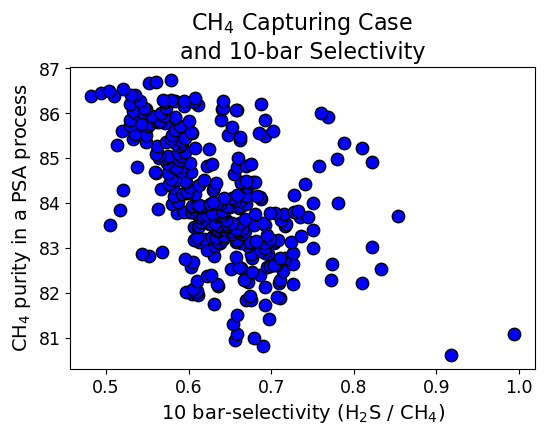

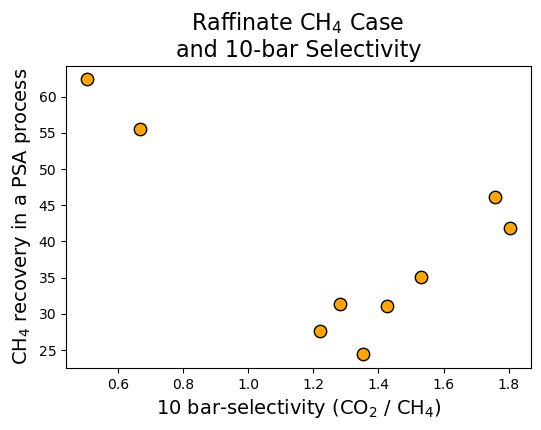

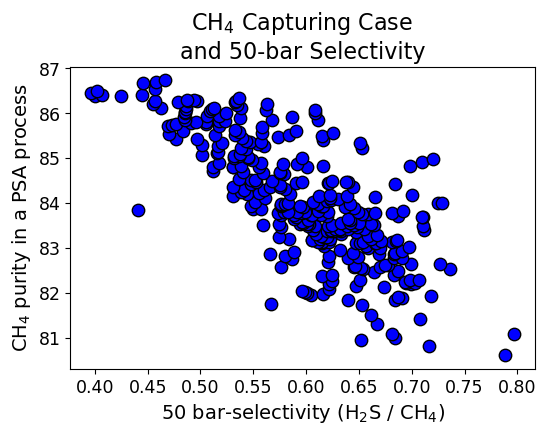

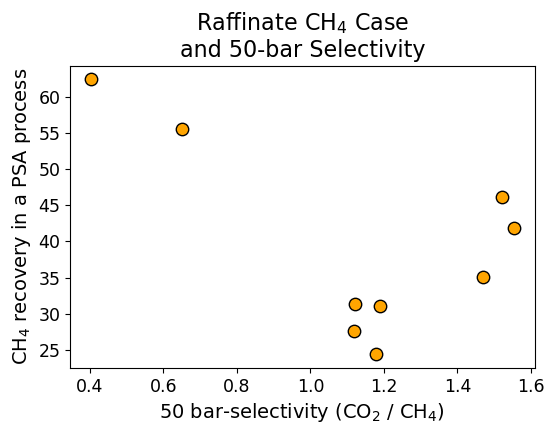

In [298]:

###############################################
#################  SRCC   #####################
###############################################

### Condition: over 20% recovery ###
s_res_H2S_CH4_raf_50 = stats.spearmanr(sel_50_H2S_CH4_raf[Recs_CH4_raf_H2S > 0.2], Recs_CH4_raf_H2S[Recs_CH4_raf_H2S > 0.2])
s_res_H2S_CH4_raf_10 = stats.spearmanr(sel_10_H2S_CH4_raf[Recs_CH4_raf_H2S > 0.2], Recs_CH4_raf_H2S[Recs_CH4_raf_H2S > 0.2])

### Condition: over 80.5% CH4 purity ###
s_res_H2S_rest_10 = stats.spearmanr(sel_10_H2S_rest[xx_rest_CH4_H2S > 0.805], xx_rest_CH4_H2S[xx_rest_CH4_H2S > 0.805])
s_res_H2S_rest_50 = stats.spearmanr(sel_50_H2S_rest[xx_rest_CH4_H2S > 0.805], xx_rest_CH4_H2S[xx_rest_CH4_H2S > 0.805])
#s_res_H2S_rest_10 = stats.spearmanr(sel_10_H2S_rest, xx_rest_CH4_H2S)
#s_res_H2S_rest_50 = stats.spearmanr(sel_50_H2S_rest, xx_rest_CH4_H2S)

print(s_res_H2S_CH4_raf_10)
print(s_res_H2S_rest_10)
print(s_res_H2S_CH4_raf_50)
print(s_res_H2S_rest_50)

###############################################
############### 10 bar  #######################
###############################################


### Scatter for CH4 capturing case (10 bar) ###
plt.figure(dpi = 100)
plt.scatter(sel_10_H2S_rest[xx_rest_CH4_H2S> 0.805], xx_rest_CH4_H2S[xx_rest_CH4_H2S > 0.805]*100, 
#plt.scatter(sel_10_H2S_rest, xx_rest_CH4_H2S*100, 
s = 80,c='blue', edgecolors= 'k',
label = 'CH$_{4}$ purity')

plt.xticks(fontsize = 12.5)
plt.yticks(fontsize = 12.5)
plt.xlabel('10 bar-selectivity (H$_{2}$S / CH$_{4}$)', fontsize = 14)
plt.ylabel('CH$_{4}$ purity in a PSA process', fontsize = 14)
plt.title('CH$_{4}$ Capturing Case \nand 10-bar Selectivity',fontsize = 16)

### Scatter for CH4 producing case (10 bar) ### 
plt.figure(dpi = 100)
plt.scatter(sel_10_H2S_CH4_raf[Recs_CH4_raf_H2S > 0.2], Recs_CH4_raf_H2S[Recs_CH4_raf_H2S > 0.2]*100,
s = 80,c='orange', edgecolors= 'k',
label = 'CH$_{4}$ recovery')
#plt.title('Raffinate CH$_4$ Case \nand 10 bar Selectivity')
plt.xlabel('10 bar-selectivity (CO$_{2}$ / CH$_{4}$)', fontsize = 14)
plt.ylabel('CH$_{4}$ recovery in a PSA process', fontsize = 14)
plt.title('Raffinate CH$_{4}$ Case \nand 10-bar Selectivity',fontsize = 16)

#plt.legend(fontsize = 14)

###############################################
############### 50 bar  #######################
###############################################

### Scatter for CH4 capturing case (50 bar) ###
plt.figure(dpi = 100)
plt.scatter(sel_50_H2S_rest[xx_rest_CH4_H2S > 0.805], xx_rest_CH4_H2S[xx_rest_CH4_H2S > 0.805]*100, 
#plt.scatter(sel_50_H2S_rest, xx_rest_CH4_H2S*100, 
s = 80,c='blue', edgecolors= 'k',
label = 'CH$_{4}$ purity')

plt.xticks(fontsize = 12.5)
plt.yticks(fontsize = 12.5)
plt.xlabel('50 bar-selectivity (H$_{2}$S / CH$_{4}$)', fontsize = 14)
plt.ylabel('CH$_4$ purity in a PSA process', fontsize = 14)
plt.title('CH$_{4}$ Capturing Case \nand 50-bar Selectivity',fontsize = 16)

### Scatter for CH4 producing case (50 bar) ###
plt.figure(dpi = 100)
plt.scatter(sel_50_H2S_CH4_raf[Recs_CH4_raf_H2S > 0.2], Recs_CH4_raf_H2S[Recs_CH4_raf_H2S > 0.2]*100,
s = 80,c='orange', edgecolors= 'k',
label = 'CH$_{4}$ recovery')
plt.xticks(fontsize = 12.5)
plt.yticks(fontsize = 12.5)
plt.xlabel('50 bar-selectivity (CO$_{2}$ / CH$_{4}$) ', fontsize = 14)
plt.ylabel('CH$_{4}$ recovery in a PSA process', fontsize = 14)
plt.title('Raffinate CH$_{4}$ Case \nand 50-bar Selectivity',fontsize = 16)


# PREVIOUS CODE

In [7]:
### CO2 Case
P_h_range = np.arange(2,18.1,0.25)
x_guess = [0.8,0.1,0.1]
y_feed_in = [0.6,0.15,0.25]# (mol/mol) feed composition
T_feed_in = 313         # (K) temperature or 298K
P_l = 1                     # (bar) vacuum pressure
T_tri = [298.15,]*3
rec_result = []
sf_result = []
sf_arg_result = []

for binn,dH,nam in zip(bins_CO2,dH_CO2,Names_CO2):
    rec_list_tmp = []
    sf_list_tmp = []
    sf_arg_list_tmp = []
    for P in P_h_range:
        rec_tmp,sf_tmp = Rec(x_guess,P,P_l,binn,dH, T_tri,y_feed_in, T_feed_in)
        rec_list_tmp.append(rec_tmp)
        sf_list_tmp.append(np.min(sf_tmp))
        sf_arg_list_tmp.append(np.argmin(sf_tmp))
    rec_list = np.array(rec_list_tmp)
    rec_result.append(rec_list)
    sf_arg_list = np.array(sf_arg_list_tmp)
    sf_arg_result.append(sf_arg_list)
    print(nam,': Rec = {0:.3f}'.format(rec_list[-1]), sf_arg_list[-1])
    sf_list = np.array(sf_list_tmp)
    sf_result.append(sf_list)
    

ACO_0 :  [0 0] 0
AEI_0 :  [44.89874093 44.79163158] 2
AEI_1 :  [0 0] 0
AEL_0 :  [0 0] 0
AEL_1 :  [0 0] 0
AEL_2 :  [0 0] 0
AET_0 :  [0 0] 0
AET_1 :  [0 0] 0
AFI_0 :  [0 0] 0
AFI_1 :  [0 0] 0
AFN_0 :  [0 0] 0
AFO_0 :  [0 0] 0
AFO_1 :  [0 0] 0
AFR_0 :  [0 0] 0
AFR_1 :  [0 0] 0
AFS_0 :  [0 0] 0
AFS_1 :  [0 0] 0
AFT_0 :  [0 0] 0
AFT_1 :  [0 0] 0
AFV :  [0 0] 0
AFX_0 :  [0 0] 0
AFX_1 :  [0 0] 0
AFY_0 :  [0 0] 0
AHT_1 :  [0 0] 0
APC_1 :  [11.68390583 11.68485709] 1
APC_2 :  [0. 0.] 0


C:\Users\LeBlanc\anaconda3\pyiast\isotherms.py:354: RuntimeWarning: invalid value encountered in log
  return self.params["M"] * np.log(1.0 + self.params["Ka"] * pressure


APD_0 :  [0 0] 0
ASV_0 :  [0 0] 0
ATN_0 :  [0 0] 0
ATN_1 :  [0 0] 0
ATO_0 :  [0 0] 0
ATO_1 :  [0 0] 0
ATS_0 :  [0 0] 0
ATS_1 :  [0 0] 0
ATT_0 :  [0 0] 0
ATT_1 :  [0 0] 0
ATV_0 :  [0 0] 0
AVE :  [0 0] 0
AVL :  [0 0] 0
AWO_0 :  [0 0] 0
AWO_1 :  [0 0] 0
AWW_0 :  [0 0] 0
BEA_0 :  [0 0] 0
BEA_1 :  [0 0] 0
BEA_B_1 :  [0 0] 0
BEC_0 :  [0 0] 0
BEC_2 :  [0 0] 0
BOF_0 :  [0 0] 0
BOG_0 :  [0 0] 0
BOG_1 :  [0 0] 0
BOZ_0 :  [0 0] 0
BPH_0 :  [0 0] 0
BRE_1 :  [0 0] 0
BSV_0 :  [0 0] 0
CAN_0 :  [0 0] 0
CAN_1 :  [0 0] 0
CDO_0 :  [0 0] 0
CDO_1 :  [51.36538611 51.34969223] 1
CFI_0 :  [0 0] 0
CFI_1 :  [0 0] 0
CGF_0 :  [0 0] 0
CGS_0 :  [0 0] 0
CHA_0 :  [0 0] 0
CLO_0 :  [0 0] 0
CON_0 :  [0 0] 0
CON_1 :  [0 0] 0
CON_2 :  [0 0] 0
CSV :  [0 0] 0
CZP_0 :  [0 0] 0
DAC_0 :  [0 0] 0
DDR_0 :  [0 0] 0
DDR_1 :  [0 0] 0
DFO_0 :  [0 0] 0
DFO_1 :  [0 0] 0
DFT_0 :  [0 0] 0
DON_0 :  [0 0] 0
DON_1 :  [0 0] 0
EAB_0 :  [0 0] 0
EAB_1 :  [0 0] 0
EAB_2 :  [0 0] 0
EDI_0 :  [0 0] 0
EDI_2 :  [0 0] 0
EMT_0 :  [0 0] 0
EMT_1 :  [0 0] 

In [8]:
### Sort CO2 Case Result!
rec_last = []
for rec_list in rec_result:
    rec_last.append(rec_list[-1])
rec_last = np.array(rec_last)
ind_des = np.argsort(rec_last, )
print(ind_des)

# Arrange with the index
rec_result_sort = np.array(rec_result)[ind_des][::-1]
sf_result_sort = np.array(sf_result)[ind_des][::-1]
Names_CO2_sort= Names_CO2[ind_des][::-1]
sf_arg_result_sort = np.array(sf_arg_result)[ind_des][::-1]


[155 203 232 231 230 229 228 227 226 233   0 224 223 222 221 220 219 218
 217 225 234 235 236 254 253 252 251 250 249 248 247 216 246 244 243 242
 241 240 239 238 237 245 215 214 213 190 189 188 187 186 185 184 183 182
 181 180 179 178 177 176 175 174 191 255 192 194 212 211 210 209 208 207
 206 205 204 202 201 200 199 198 197 196 195 193 257 258 259 320 319 318
 317 316 315 314 313 312 311 310 309 308 307 306 305 304 321 322 323 324
 344 343 342 339 338 337 336 335 303 334 332 331 330 329 328 327 326 325
 333 302 301 300 277 276 275 274 273 272 271 270 278 269 267 266 265 264
 263 262 261 260 268 345 279 281 299 298 297 296 295 294 293 292 280 291
 289 288 287 286 285 284 283 282 290 172 173 170  63  62  61  60  59  58
  56  55  54  53  52  51  50  49  48  47  46  64  45  65  67 171  83  82
  81  80  79  78  77  76  75  74  73  72  71  70  69  68  66  44  43  42
  18  17  16  15  14  13  12  11  10   9   8   7   6   5   4   3   2  19
  20  21  22  41  40  39  38  37  36  35  34  85  3

In [19]:
print(P_h_range[7])
print(rec_result_sort[0][7])
print(P_h_range[44])
print(rec_result_sort[0][44])
top5_5bar = []
top5_10bar = []
for rr in rec_result_sort[0:]:
    top5_5bar.append(rr[7])
    top5_10bar.append(rr[44])
print(Names_CO2_sort[0:])
print(top5_5bar)
print(top5_10bar)
print(' ')

3.75
43.946196134128876
13.0
51.31399769302198
['CDO_1' 'AEI_0' 'WEI_0' 'VSV_0' 'JBW_0' 'RRO_0' 'APC_1' 'GIS_4' 'FER_0'
 'FER_1' 'FER_2' 'GIS_0' 'GIS_1' 'GIS_2' 'GIS_3' 'ZON_1' 'GIS_5' 'GIS_6'
 'FAU_6' 'GME_1' 'GON_0' 'GON_1' 'GOO_0' 'HEU_0' 'GME_0' 'FAU_3' 'FAU_5'
 'ETR_1' 'EPI_1' 'ERI_0' 'ERI_1' 'ERI_2' 'ESV_0' 'ESV_1' 'ETL' 'ETR_0'
 'EUO_0' 'FAU_4' 'EUO_1' 'EWS' 'EZT_0' 'EZT_1' 'FAU_0' 'FAU_1' 'FAU_2'
 'HEU_2' 'HEU_1' 'IFR_1' 'IFO_0' 'ITH_1' 'ITR_1' 'ITT_0' 'ITV_0' 'ITW_0'
 'IWR_0' 'IWR_1' 'IWS_0' 'IWS_1' 'IWV_0' 'IWV_1' 'IWW_0' 'IWW_1' 'JOZ_0'
 'JRY_0' 'JSN_0' 'JSN_1' 'JSR_0' 'ITR_0' 'ITH_0' 'IFO_1' 'ITG' 'IFR_0'
 'IFT' 'IFU' 'IFW' 'IFY' 'IHW_0' 'IHW_1' 'IMF_0' 'IMF_1' 'IRN' 'IRR_0'
 'IRR_1' 'IRY' 'ISV_0' 'ISV_1' 'ITE_0' 'ITE_1' 'EPI_0' 'EMT_2' 'EON_1'
 'ATS_0' 'AHT_1' 'APC_2' 'APD_0' 'ASV_0' 'ATN_0' 'ATN_1' 'ATO_0' 'ATO_1'
 'ATS_1' 'EON_0' 'ATT_0' 'ATT_1' 'ATV_0' 'AVE' 'AVL' 'AWO_0' 'AWO_1'
 'AWW_0' 'AFY_0' 'AFX_1' 'AFX_0' 'AFV' 'AEI_1' 'AEL_0' 'AEL_1' 'AEL_2'
 'AET_0' 'AET_1' 'AF

In [20]:
print(P_h_range[7])
print(sf_result_sort[0][7])
print(P_h_range[44])
print(sf_result_sort[0][44])
top5_5bar = []
top5_15bar = []
top5_5bar_arg = []
top5_15bar_arg = []
for rr in sf_result_sort[0:7]:
    top5_5bar.append(rr[7])
    top5_15bar.append(rr[44])
for rr in sf_arg_result_sort[0:7]:
    top5_5bar_arg.append(rr[7])
    top5_15bar_arg.append(rr[44])
print(Names_CO2_sort[0:7])
print(np.array(top5_5bar)*100)
print(np.array(top5_15bar)*100)
print(top5_5bar_arg)
print(top5_15bar_arg)      

3.75
0.9985917193581256
13.0
0.9597101912485684
['CDO_1' 'AEI_0' 'WEI_0' 'VSV_0' 'JBW_0' 'RRO_0' 'APC_1']
[99.85917194 82.88089174 95.27071916 86.56299993 99.44173165 77.78968113
 95.30768281]
[95.97101912 78.31155111 87.1884532  78.37722424 73.10683169 56.73516596
 57.6347586 ]
[1, 2, 2, 2, 2, 2, 1]
[1, 2, 1, 2, 1, 2, 1]


In [21]:
print(Names_CO2_sort)
print(rec_result_sort)
np.reshape

['CDO_1' 'AEI_0' 'WEI_0' 'VSV_0' 'JBW_0' 'RRO_0' 'APC_1' 'GIS_4' 'FER_0'
 'FER_1' 'FER_2' 'GIS_0' 'GIS_1' 'GIS_2' 'GIS_3' 'ZON_1' 'GIS_5' 'GIS_6'
 'FAU_6' 'GME_1' 'GON_0' 'GON_1' 'GOO_0' 'HEU_0' 'GME_0' 'FAU_3' 'FAU_5'
 'ETR_1' 'EPI_1' 'ERI_0' 'ERI_1' 'ERI_2' 'ESV_0' 'ESV_1' 'ETL' 'ETR_0'
 'EUO_0' 'FAU_4' 'EUO_1' 'EWS' 'EZT_0' 'EZT_1' 'FAU_0' 'FAU_1' 'FAU_2'
 'HEU_2' 'HEU_1' 'IFR_1' 'IFO_0' 'ITH_1' 'ITR_1' 'ITT_0' 'ITV_0' 'ITW_0'
 'IWR_0' 'IWR_1' 'IWS_0' 'IWS_1' 'IWV_0' 'IWV_1' 'IWW_0' 'IWW_1' 'JOZ_0'
 'JRY_0' 'JSN_0' 'JSN_1' 'JSR_0' 'ITR_0' 'ITH_0' 'IFO_1' 'ITG' 'IFR_0'
 'IFT' 'IFU' 'IFW' 'IFY' 'IHW_0' 'IHW_1' 'IMF_0' 'IMF_1' 'IRN' 'IRR_0'
 'IRR_1' 'IRY' 'ISV_0' 'ISV_1' 'ITE_0' 'ITE_1' 'EPI_0' 'EMT_2' 'EON_1'
 'ATS_0' 'AHT_1' 'APC_2' 'APD_0' 'ASV_0' 'ATN_0' 'ATN_1' 'ATO_0' 'ATO_1'
 'ATS_1' 'EON_0' 'ATT_0' 'ATT_1' 'ATV_0' 'AVE' 'AVL' 'AWO_0' 'AWO_1'
 'AWW_0' 'AFY_0' 'AFX_1' 'AFX_0' 'AFV' 'AEI_1' 'AEL_0' 'AEL_1' 'AEL_2'
 'AET_0' 'AET_1' 'AFI_0' 'AFI_1' 'AFN_0' 'AFO_0' 'AFO_1' 'AFR_0' 'A

<function numpy.reshape(a, newshape, order='C')>

(2.0, 14.8)

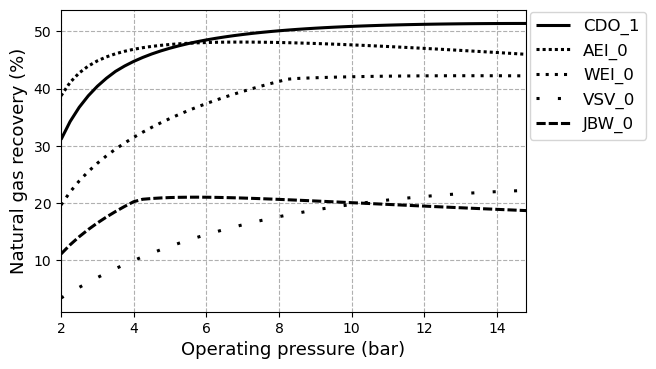

In [23]:
### Line Styles
line_len = [1,3,5]
space_len = [1,2,4]
L_styles = [(0,())]
for line in line_len:
        for space in space_len:
            style_temp = (line, space)
            L_styles.append((0,style_temp))
### Plotting
dpi = 100
plt.figure(dpi = dpi)
c_for = 0
c_pl = 0
for re,nam in zip(rec_result_sort,Names_CO2_sort[0]):
    plt.plot(P_h_range, re,'k', ls =L_styles[c_for], lw = 2.2)
    c_for = c_for+1
    c_pl = c_pl +1
    if c_for > len(L_styles)-1:c_for = 0

plt.legend(Names_CO2_sort[:20],fontsize = 12, bbox_to_anchor=(0.99, 1.02), loc='upper left')
plt.grid(ls = '--')
plt.xlabel('Operating pressure (bar)',fontsize = 13)
plt.ylabel('Natural gas recovery (%)',fontsize = 13)
plt.xlim([2,14.8])
#plt.ylim([40,90])

18041N3


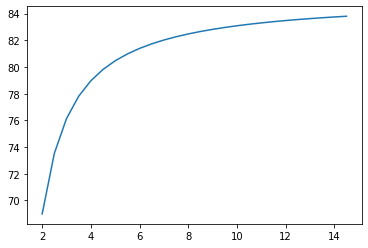

In [97]:
rec_col = []
x_guess = [0.8,0.05,0.15]
P_l = 0.7
print(Names_H2S[2])
P_h_ran = np.arange(2,15,0.5)
for P in P_h_ran:
    rec_tmp,sf_tmp = Rec(x_guess,P,P_l,
                        bins_H2S[2],dH_H2S[2], T_tri,
                        y_feed_in, T_feed_in)
    rec_col.append(rec_tmp)
plt.figure()
plt.plot(P_h_ran,np.array(rec_col))
#cc = np.arange(1,11)
#x_col = []
#xxx = x_guess
#for c in cc:
#    x_col.append(xxx)
#    xxx = x2x(xxx,3,1,bin,dH,T_tri,y_feed_in,T_feed_in)
#plt.plot(cc,np.array(x_col)[:,1])

In [ ]:
### H2S Case
P_h_range = np.arange(4,20.1,0.25)
x_guess = [0.7,0.15,0.15]
y_feed_in = [0.6,0.15,0.25] # (mol/mol) feed composition
T_feed_in = 313             # (K) temperature or 317K
P_l = 1   # (bar) vacuum pressure
T_tri = [298.15,]*3
rec_result = []
sf_result = []
for bin,dH,nam in zip(bins_H2S,dH_H2S,Names_H2S):
    rec_list_tmp = []
    sf_list_tmp = []
    sf_arg_list_tmp = []
    for P in P_h_range:
        rec_tmp,sf_tmp = Rec(x_guess,P,P_l,bin,dH, T_tri,y_feed_in, T_feed_in)
        rec_list_tmp.append(rec_tmp)
        sf_list_tmp.append(np.min(sf_tmp))
        sf_arg_list_tmp.append(np.argmin(sf_tmp))
    rec_list = np.array(rec_list_tmp)
    rec_result.append(rec_list)
    sf_arg_list = np.array(sf_arg_list_tmp)
    sf_arg_result.append(sf_arg_list)
    print(nam,': ', rec_list[-2:], sf_arg_list[-1])
    sf_list = np.array(sf_list_tmp)
    sf_result.append(sf_list)

ACO_0 :  [0 0] 0
AEI_0 :  [43.93837732 43.83120992] 2
AEI_1 :  [0 0] 0
AFN_0 :  [0 0] 0
AFT_0 :  [0 0] 0
AFT_1 :  [0 0] 0
AFV :  [0 0] 0
AFX_0 :  [0 0] 0
AFX_1 :  [0 0] 0
AHT_1 :  [0 0] 0
APC_1 :  [11.36063204 11.36228849] 1
APC_2 :  [0. 0.] 0


C:\Users\LeBlanc\anaconda3\pyiast\isotherms.py:354: RuntimeWarning: invalid value encountered in log
  return self.params["M"] * np.log(1.0 + self.params["Ka"] * pressure


APD_0 :  [0 0] 0
ATT_0 :  [0 0] 0
ATT_1 :  [0 0] 0
ATV_0 :  [0 0] 0
AVE :  [0 0] 0
AVL :  [0 0] 0
AWO_0 :  [0 0] 0
AWO_1 :  [0 0] 0
BRE_1 :  [0 0] 0
BSV_0 :  [0 0] 0
CDO_0 :  [0 0] 0
CDO_1 :  [51.13971525 51.11811723] 1
CGF_0 :  [0 0] 0
CHA_0 :  [0 0] 0
CZP_0 :  [0 0] 0
DAC_0 :  [0 0] 0
DDR_0 :  [0 0] 0
DDR_1 :  [0 0] 0
DFT_0 :  [0 0] 0
EAB_0 :  [0 0] 0
EAB_1 :  [0 0] 0
EAB_2 :  [0 0] 0
EDI_0 :  [0 0] 0
EDI_2 :  [0 0] 0
EPI_0 :  [0 0] 0
EPI_1 :  [0 0] 0
ERI_0 :  [0 0] 0
ERI_1 :  [0 0] 0
ERI_2 :  [0 0] 0
ESV_0 :  [0 0] 0
ESV_1 :  [0 0] 0
ETL :  [0 0] 0
EWS :  [0 0] 0
GIS_0 :  [0 0] 0
GIS_1 :  [0 0] 0
GIS_2 :  [0 0] 0
GIS_3 :  [0 0] 0
GIS_4 :  [0 0] 0
GIS_5 :  [0 0] 0
GIS_6 :  [0 0] 0
GOO_0 :  [0 0] 0
HEU_0 :  [0 0] 0
HEU_1 :  [0 0] 0
HEU_2 :  [0 0] 0
IFY :  [0 0] 0
IHW_0 :  [0 0] 0
IHW_1 :  [0 0] 0
IRN :  [0 0] 0
ITE_1 :  [0 0] 0
ITW_0 :  [0 0] 0
ITW_1 :  [-2.99163091 -2.94727097] 2
JBW_0 :  [17.55251547 17.50103468] 1
JOZ_0 :  [0 0] 0
JSN_0 :  [0 0] 0
JSN_1 :  [0 0] 0
JST_0 :  [0 0] 0


In [ ]:
### Sort H2S Case Result!
rec_last = []
for rec_list in rec_result:
    rec_last.append(rec_list[-1])
rec_last = np.array(rec_last)
ind_des = np.argsort(rec_last, )
print(ind_des)

# Arrange with the index
rec_result_sort = np.array(rec_result)[ind_des][::-1]
sf_result_sort = np.array(sf_result)[ind_des][::-1]
Names_H2S_sort= Names_H2S[ind_des][::-1]


In [ ]:
print(P_h_range[4])
print(rec_result_sort[0][4])
print(P_h_range[44])
print(rec_result_sort[0][44])
top5_5bar = []
top5_10bar = []
for rr in rec_result_sort[0:]:
    top5_5bar.append(rr[4])
    top5_10bar.append(rr[44])
print(Names_H2S_sort[0:])
print(top5_5bar)
print(top5_10bar)

In [ ]:
### Plotting H2S case
# Line Styles
line_len = [1,3,5]
space_len = [1,2]
L_styles = [(0,())]
for line in line_len:
        for space in space_len:
            style_temp = (line, space)
            L_styles.append((0,style_temp))
# Plotting
dpi = 100
plt.figure(dpi = dpi)
c_for = 0
c_pl = 0
for re,nam in zip(rec_result_sort,Names_H2S_sort):
    plt.plot(P_h_range, re,'k', ls =L_styles[c_for], lw = 2.2)
    c_for = c_for+1
    c_pl = c_pl + 1
    if c_pl >= 10: break
    if c_for > len(L_styles)-1:c_for = 0
    

plt.legend(Names_H2S_sort[0:10],fontsize = 12, bbox_to_anchor=(0.99, 1.02), loc='upper left')
plt.grid(ls = '--')
plt.xlabel('Operating pressure (bar)',fontsize = 13)
plt.ylabel('Natural gas recovery (%)',fontsize = 13)
plt.xlim([4.6,20.8])
plt.ylim([45,95])

In [ ]:
### CO2 Case
yh2s = np.arange(0.03, 0.371, 0.01)
x_guess = [0.8,0.1,0.1]
y_feed_in = [0.6,0.15,0.25] # (mol/mol) feed composition
T_feed_in = 313             # (K) temperature or 317K
P_h = 5     # (bar) compressed prssure
P_l = 0.5   # (bar) vacuum pressure
T_tri = [298.15,]*3
rec_result = []
sf_result = []
for bin,dH,nam in zip(bins_CO2,dH_CO2,Names_CO2):
    rec_list_tmp = []
    sf_list_tmp = []
    for yy in yh2s:
        rec_tmp,sf_tmp = Rec(x_guess,P_h,P_l,
                             bin,dH, T_tri,
                             [y_feed_in[0], yy, 0.4-yy], T_feed_in)
        rec_list_tmp.append(rec_tmp)
        sf_list_tmp.append(np.min(sf_tmp))
    rec_list = np.array(rec_list_tmp)
    rec_result.append(rec_list)
    sf_list = np.array(sf_list_tmp)
    sf_result.append(sf_list)


C:\Users\LeBlanc\anaconda3\pyiast\isotherms.py:354: RuntimeWarning: invalid value encountered in log
  return self.params["M"] * np.log(1.0 + self.params["Ka"] * pressure


In [ ]:
### Sort ! # CO2 case
rec_last = []
for rec_list in rec_result:
    rec_last.append(rec_list[-1])
rec_last = np.array(rec_last)
ind_des = np.argsort(rec_last, )
print(ind_des)

# Arrange with the index
rec_result_sort = np.array(rec_result)[ind_des][::-1]
sf_result_sort = np.array(sf_result)[ind_des][::-1]
Names_CO2_sort= Names_CO2[ind_des][::-1]


In [ ]:
### Line Styles
line_len = [1,3,5]
space_len = [1,2,4]
L_styles = [(0,())]
for line in line_len:
        for space in space_len:
            style_temp = (line, space)
            L_styles.append((0,style_temp))
### Plotting
plt.figure()
c_for = 0
c_pl = 0
for re,nam in zip(rec_result_sort,Names_CO2):
    plt.plot(yh2s, re,'k', ls =L_styles[c_for], lw = 2.2)
    c_for = c_for+1
    c_pl = c_pl+1
    if c_pl >= 8: break
    if c_for > len(L_styles)-1:c_for = 0
    
plt.legend(Names_CO2_sort[0:8],fontsize = 12,
           bbox_to_anchor=(0.99, 1.02), loc='upper left')
plt.grid(ls = '--')
plt.title('Natural Gas Recovery', fontsize=15.5)
plt.xlabel('$y_{H_2S} = 0.3-y_{CO_2}$(mol/mol)',fontsize = 13)
plt.ylabel('recovery (%)',fontsize = 13)
plt.ylim([53,90])
#plt.ylim([85.7,87])

## Saturation region
dpi = 100
plt.figure(dpi = dpi)
c_for = 0
c_pl = 0
for re,nam in zip(sf_result_sort,Names_CO2):
    plt.plot(yh2s, re*100,'k', ls =L_styles[c_for], lw = 2.2)
    c_for = c_for+1
    c_pl = c_pl +1 
    if c_pl >= 8: break
    if c_for > len(L_styles)-1:c_for = 0
    
plt.legend(Names_CO2_sort[0:8],fontsize = 12,
           bbox_to_anchor=(0.99, 1.02), loc='upper left')
plt.grid(ls = '--')
plt.title('Use of Bed Capacity', fontsize=15.5)
plt.xlabel('$y_{H_2S} = 0.3-y_{CO_2}$(mol/mol)',fontsize = 13)
plt.ylabel('Saturation region fraction (%)',fontsize = 13)


In [ ]:
### CO2 Case
yh2s = np.arange(0.03, 0.371, 0.01)
x_guess = [0.8,0.1,0.1]
y_feed_in = [0.6,0.15,0.25] # (mol/mol) feed composition
T_feed_in = 313             # (K) temperature or 317K
P_h = 5     # (bar) compressed prssure
P_l = 0.5   # (bar) vacuum pressure
T_tri = [298.15,]*3

rec_result = []
sf_result = []
for bin,dH,nam in zip(bins_H2S,dH_H2S,Names_H2S):
    rec_list_tmp = []
    sf_list_tmp = []
    for yy in yh2s:
        sum_sign = 0
        sum_sign_1 = 0
        sum_sign_2 = 0
        for k in range(3):
            sum_sign = sum_sign + np.sign(bin[k].params['K1'])
            sum_sign = sum_sign + np.sign(bin[k].params['K2'])
            sum_sign_1 = sum_sign_1 + np.sign(bin[k].params['M1'])
            sum_sign_2 = sum_sign_2 + np.sign(bin[k].params['M2'])
        if sum_sign < 5.7:
            rec_tmp = -1
            sf_tmp = -1
        elif sum_sign_1 < 0:
            rec_tmp = -2
            sf_tmp = -2
        elif sum_sign_2 < 2.5:
            rec_tmp = -3
            sf_tmp = -3
        else:
            rec_tmp,sf_tmp = Rec(x_guess,P_h,P_l,
                                 bin,dH, T_tri,
                                 [y_feed_in[0], yy, 0.4-yy], T_feed_in)
                    
        rec_list_tmp.append(rec_tmp)
        sf_list_tmp.append(np.min(sf_tmp))
    rec_list = np.array(rec_list_tmp)
    rec_result.append(rec_list)
    print('{:5s} : '.format(nam), rec_list[-5:])

    sf_list = np.array(sf_list_tmp)
    sf_result.append(sf_list)


In [ ]:
### Sort ! # H2S case
rec_last = []
for rec_list in rec_result:
    rec_last.append(rec_list[-1])
rec_last = np.array(rec_last)
ind_des = np.argsort(rec_last, )
print(ind_des)

# Arrange with the index
rec_result_sort = np.array(rec_result)[ind_des][::-1]
sf_result_sort = np.array(sf_result)[ind_des][::-1]
Names_H2S_sort= Names_H2S[ind_des][::-1]


In [ ]:
### Line Styles
line_len = [1,3,5]
space_len = [1,2,4]
L_styles = [(0,())]
for line in line_len:
        for space in space_len:
            style_temp = (line, space)
            L_styles.append((0,style_temp))
### Plotting
dpi = 100
plt.figure(dpi = dpi)
c_for = 0
c_pl = 0
for re,nam in zip(rec_result_sort,Names_CO2):
    plt.plot(yh2s, re,'k', ls =L_styles[c_for], lw = 2.2)
    c_for = c_for+1
    c_pl = c_pl+1
    if c_pl >= 8: break
    if c_for > len(L_styles)-1:c_for = 0
    
plt.legend(Names_H2S_sort[0:8],fontsize = 12,
           bbox_to_anchor=(0.99, 1.02), loc='upper left')
plt.grid(ls = '--')
plt.title('Natural Gas Recovery', fontsize=15.5)
plt.xlabel('$y_{H_2S} = 0.3-y_{CO_2}$(mol/mol)',fontsize = 13)
plt.ylabel('recovery (%)',fontsize = 13)
plt.ylim([53,90])
#plt.ylim([85.7,87])

## Saturation region
dpi = 100
plt.figure(dpi = dpi)
c_for = 0
c_pl = 0
for re,nam in zip(sf_result_sort,Names_CO2):
    plt.plot(yh2s, re*100,'k', ls =L_styles[c_for], lw = 2.2)
    c_for = c_for+1
    c_pl = c_pl +1 
    if c_pl >= 8: break
    if c_for > len(L_styles)-1:c_for = 0
    
plt.legend(Names_H2S_sort[0:8],fontsize = 12,
           bbox_to_anchor=(0.99, 1.02), loc='upper left')
plt.grid(ls = '--')
plt.title('Use of Bed Capacity', fontsize=15.5)
plt.xlabel('$y_{H_2S} = 0.3-y_{CO_2}$(mol/mol)',fontsize = 13)
plt.ylabel('Saturation region fraction (%)',fontsize = 13)

In [ ]:
### CO2 Case
ych4 = np.arange(0.4, 0.82, 0.05)
x_guess = [0.8,0.1,0.1]
y_feed_in = [0.6,0.15,0.25] # (mol/mol) feed composition
T_feed_in = 313             # (K) temperature or 317K
P_h = 5     # (bar) compressed prssure
P_l = 0.5   # (bar) vacuum pressure
T_tri = [298.15,]*3
rec_result = []
sf_result = []
for bin,dH,nam in zip(bins_CO2,dH_CO2,Names_CO2):
    rec_list_tmp = []
    sf_list_tmp = []
    for yy in ych4:
        rec_tmp,sf_tmp = Rec(x_guess,P_h,P_l,
                             bin,dH, T_tri,
                             [yy, 3/8*(1-yy), 5/8*(1-yy)], T_feed_in)
        rec_list_tmp.append(rec_tmp)
        sf_list_tmp.append(np.min(sf_tmp))
    rec_list = np.array(rec_list_tmp)
    rec_result.append(rec_list)
    sf_list = np.array(sf_list_tmp)
    sf_result.append(sf_list)

In [ ]:
### Sort ! # CO2 case
rec_last = []
for rec_list in rec_result:
    rec_last.append(rec_list[-1])
rec_last = np.array(rec_last)
ind_des = np.argsort(rec_last, )
print(ind_des)

# Arrange with the index
rec_result_sort = np.array(rec_result)[ind_des][::-1]
sf_result_sort = np.array(sf_result)[ind_des][::-1]
Names_CO2_sort= Names_CO2[ind_des][::-1]


In [ ]:
### Line Styles
line_len = [1,3,5]
space_len = [1,2]
L_styles = [(0,())]
for line in line_len:
        for space in space_len:
            style_temp = (line, space)
            L_styles.append((0,style_temp))
### Plotting
dpi = 100
plt.figure(dpi = dpi)
c_for = 0
c_pl = 0
for re,nam in zip(rec_result_sort,Names_CO2):
    plt.plot(ych4, re,'k', ls =L_styles[c_for], lw = 2.2)
    c_for = c_for+1
    c_pl = c_pl+1
    if c_pl >= 10: break
    if c_for > len(L_styles)-1:c_for = 0
plt.legend(Names_CO2_sort[0:10],fontsize = 12,
           bbox_to_anchor=(0.99, 1.02), loc='upper left')
plt.grid(ls = '--')
plt.title('Natural Gas Recovery', fontsize=15.5)
plt.xlabel('$y_{CH_4}$ (mol/mol)',fontsize = 13)
plt.ylabel('recovery (%)',fontsize = 13)
plt.ylim([50,90])
#plt.ylim([85.7,87])

## Saturation region
dpi = 100
plt.figure(dpi = dpi)
c_for = 0
c_pl = 0
for re,nam in zip(sf_result_sort,Names_CO2):
    plt.plot(ych4, re*100,'k', ls =L_styles[c_for], lw = 2.2)
    c_for = c_for+1
    c_pl = c_pl +1 
    if c_pl >= 10: break
    if c_for > len(L_styles)-1:c_for = 0
plt.legend(Names_CO2_sort[0:10],fontsize = 12,
           bbox_to_anchor=(0.99, 1.02), loc='upper left')
plt.grid(ls = '--')
plt.title('Use of Bed Capacity', fontsize=15.5)
plt.xlabel('$y_{CH_4}$ (mol/mol)',fontsize = 13)
plt.ylabel('Saturation region fraction (%)',fontsize = 13)


In [ ]:
numb = 1
for recc in rec_result_sort:
    print(numb,': ', recc[0])
    numb = numb+1

In [ ]:
## Count errors
n_err = 0
for res in rec_result_sort[::-1]:
    if res[-1] >= 0: break
    #print(res[-1])
    n_err = n_err + 1    
print('Number of error casess: ', n_err)
print('                         out of ', len(rec_result_sort))